# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import sys
import os
import time
from datetime import datetime
from importlib import reload
import pickle
from pprint import pprint
from pathlib import Path
from tqdm.notebook import tqdm

# sklearn imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import t

# tensorflow and keras imports
import tensorflow.keras.initializers
from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# to make this notebook's output stable across runs
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# surpress scientific notation
pd.options.display.float_format = '{:.8f}'.format

# custom library with functions
py_file_location = '../'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path

from customdslib import model_analysis as ma
from customdslib import preprocessing as pre
from customdslib import plotting

# custom class for alpha_t-RIM
py_file_location = '../customdslib/'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path
from alphatRIM import RIMCell


In [2]:
# imports for plotting
from matplotlib import rcParams
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
matplotlib_axes_logger.setLevel('ERROR')


# global custom setting for the running commands matplotlib or sns
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['scatter.marker'] = 'o'

sns.set_style('whitegrid', {'axes.facecolor': '.995'})

# use the custom style sheet 
plt.style.use('nk_ML_DS.mplstyle')  

# Computing environment
<a id="Versions" > 

In [3]:
%reload_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,matplotlib,pandas,seaborn


Author: Nicole Königstein
2021-08-18 

CPython 3.7.3
IPython 7.19.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 20.2.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
CPython 3.7.3
IPython 7.19.0

numpy 1.19.5
matplotlib 3.4.2
pandas 1.2.3
seaborn 0.11.1


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpu_devices, 'GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('Using GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('Using CPU')

Using CPU


# Notebook running settings

### Model training

In [4]:
# Set to False if you don't wish to train the models
do_training = True

### Cross validation

<font color=red><b>WARNING:</b> Changing this to `True` will take many hours to run.</font>

In [5]:
# if the CV will be performed or not
cross_val = False 

# how many iterations for the Randomized serach
n_iter = 700 # worked fine with 200 and 5 fold

# if the serach will be performed in parallel or not, -1 means parallel choose one to not running parallel
n_jobs = -1  

#### Use cross validation data

In [6]:
# which parameters of the cross validation to use for training the model
run_1 = True
run_2 = False

# if cross validation data should be used
use_cv = True

### Training window

In [7]:
# the input lags 
n_steps = 5

# the prediction horizon
n_steps_ahead = 5

### Training settings

In [8]:
# max number of epochs to perform the training
max_epochs = 2000

# if a batch size will be used
batch_size = None

# early stopping to prevend overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, min_delta=3e-5, restore_best_weights=True)

### Metrics

In [9]:
metrics = ['mse', 'mae']

### Uni- or Mulitvariate

In [10]:
# set to uni to just train on the price
uni = True

## Datapath

In [11]:
PATH = '../'

# Load data

### Get data

In [12]:
ticker = 'AMZN'

In [13]:
df1 = pd.read_csv(PATH + 'data/df_cut.csv')
df2 = pd.read_csv(PATH + 'data/df_cut2.csv')

data1 = df1.loc[df1['ticker'] == ticker]
data2 = df2.loc[df2['ticker'] == ticker]

In [14]:
data1.head()

Unnamed: 0 ticker        date  article_count        close           n  \
0           0   AMZN  2015-01-02     2.00000000 308.51998901  2.00000000   
1           1   AMZN  2015-01-05     1.00000000 302.19000244  0.00000000   
2           2   AMZN  2015-01-06    30.00000000 297.35530121  4.00000000   
3           3   AMZN  2015-01-07    19.00000000 298.42001343  5.00000000   
4           4   AMZN  2015-01-08    27.00000000 300.45999146 10.00000000   

            p   sentiment  conv_filter  
0  0.00000000 -1.09861229   0.32360229  
1  1.00000000  0.69314718   0.33997585  
2 26.00000000  1.68639895   0.34594188  
3 14.00000000  0.91629073   0.34450627  
4 17.00000000  0.49247649   0.35915787

In [15]:
if uni:
    data1 = data1[['close', 'date']]
    data2 = data2[['close', 'date']]
else:
    data1 = data1[['close', 'conv_filter', 'date']]
    data2 = data2[['close', 'conv_filter', 'date']]


# convert date object to datetime
format = '%Y-%m-%d'
data1['date'] = pd.to_datetime(data1['date'], format=format)
data1.set_index('date', inplace=True)

data2['date'] = pd.to_datetime(data2['date'], format=format)
data2.set_index('date', inplace=True)


data1.head()

close
date                   
2015-01-02 308.51998901
2015-01-05 302.19000244
2015-01-06 297.35530121
2015-01-07 298.42001343
2015-01-08 300.45999146

# Prepare dataset

### Split the dataset

In [16]:
mu, sigma, data_train, data_val, data_test =  pre.prepare_data_val(data1, data2, weight=0.6, log_=True)

### Get lagged features

In [17]:
x_train, y_train = pre.get_lagged_dataset(data_train, n_steps, n_steps_ahead)
x_val, y_val = pre.get_lagged_dataset(data_val, n_steps, n_steps_ahead)
x_test, y_test = pre.get_lagged_dataset(data_test, n_steps, n_steps_ahead)

# Display the shapes
print([tensor.shape for tensor in (x_train, y_train, x_val, y_val, x_test, y_test)])

[(1249, 5, 1), (1249, 5, 1), (157, 5, 1), (157, 5, 1), (102, 5, 1), (102, 5, 1)]


# Model functions

In [18]:
# if univariate or multivariate 
input_size = x_train.shape[-1]

In [19]:
input_shape = (x_train.shape[1], x_train.shape[-1])  # input lags, features

n_units = 6
l1_reg = 0
nRIM = 12
k = 12
input_key_size = 4
input_value_size = 6
input_query_size = 6
input_keep_prob = 0.9
num_comm_heads = 4
comm_key_size = 6
comm_value_size = 6
comm_query_size = 6
comm_keep_prob = 0.9


def RIM_(n_units=n_units, nRIM=nRIM, k=k, input_key_size=input_key_size, input_value_size=input_value_size,
         input_query_size=input_query_size, input_keep_prob=input_keep_prob, num_comm_heads=num_comm_heads,
         comm_key_size=comm_key_size, comm_value_size=comm_value_size, comm_query_size=comm_query_size, comm_keep_prob=comm_keep_prob, metrics = ['mse']):

    rnn_cell = RIMCell(units=n_units, nRIM=nRIM, k=k,
                       num_input_heads=input_size, input_key_size=input_key_size,
                       input_value_size=input_value_size, input_query_size=input_query_size,
                       input_keep_prob=input_keep_prob, num_comm_heads=num_comm_heads,
                       comm_key_size=comm_key_size, comm_value_size=comm_value_size,
                       comm_query_size=comm_query_size, comm_keep_prob=comm_keep_prob)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(
        [n_steps, input_size], batch_size=batch_size))
    model.add(tf.keras.layers.RNN(cell=rnn_cell,
                                  return_sequences=False, return_state=False))
    model.add(tf.keras.layers.Dense(n_steps_ahead))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = metrics)

    return model

In [20]:
params = {
    'alpha_t_RIM': {
        'model': None, 'network': RIM_, 'n_units': 6, 'num_comm_heads': 6,
        'nRIM': 14, 'k': 12, 'input_value_size': 6,
        'input_query_size': 4, 'input_key_size': 4,
        'input_keep_prob': 0.7, 'comm_value_size': 8,
        'comm_query_size': 4, 'comm_key_size': 4,
        'comm_keep_prob': 0.9, 'color': '#d3d1d1', 'label': 'RIM-alpha_t'}
}

# Cross-validation

As we have some parameters which aren't valid combinations for the RIM, we need to exclude these parameters from the grid search. This was done by manually computing a list of dictionaries. To avoid computational overhead, we compute this list once and just load it into memory, if we do the cross validation. The listed parameters will be tested, excluding the parameter combinations, if the `nRIM < k` and `input_key_size != input_query_size` and `comm_key_size != comm_query_size`.


* n_units = [4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30]
* nRIM = [4, 6, 8, 10, 12, 14]
* k = [4, 6, 8, 10, 12, 14]
* input_key_size = [4, 6, 8, 10, 12]
* input_value_size = [4, 6, 8, 10, 12]
* input_query_size = [4, 6, 8, 10, 12]
* input_keep_prob = [0.6, 0.7, 0.8, 0.9]
* num_comm_heads = [2, 4, 6, 8]
* comm_key_size = [4, 6, 8, 10, 12]
* comm_value_size = [4, 6, 8, 10, 12]
* comm_query_size = [4, 6, 8, 10, 12]
* comm_keep_prob = [0.6, 0.7, 0.8, 0.9]

In [21]:
# we need to reshape the data to fit the model
y_train = y_train.reshape(-1, n_steps_ahead)


if do_training and cross_val:
    
    # Load the list with the parameters to test
         
    file_name = PATH + 'filtered_params/filtered_params.pkl'
    open_file = open(file_name, "rb")
    filtered_params = pickle.load(open_file)
    open_file.close()
        
    # In the kth split, TimeSeriesSplit returns first k folds
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits=3)

    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        networktime = time.time()
        print('Performing cross-validation on model:', key)
        model = KerasRegressor(build_fn=params[key]['network'], epochs=max_epochs,
                               batch_size=batch_size, verbose=0)
        grid = RandomizedSearchCV(estimator=model, param_distributions=filtered_params, n_iter=n_iter,
                            cv=tscv, n_jobs=n_jobs, verbose=3, return_train_score=True, error_score = -1000)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best score: %f using parameter %s" %
              (grid_result.best_score_, grid_result.best_params_))
        print("Network Runtime: %0.2f Minutes" %
              ((time.time() - networktime)/60))

        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['n_units'] = grid_result.best_params_['n_units']
        params[key]['nRIM'] = grid_result.best_params_['nRIM']
        params[key]['k'] = grid_result.best_params_['k']
        params[key]['input_key_size'] = grid_result.best_params_['input_key_size']
        params[key]['input_value_size'] = grid_result.best_params_['input_value_size']
        params[key]['input_query_size'] = grid_result.best_params_['input_query_size']
        params[key]['input_keep_prob'] = grid_result.best_params_['input_keep_prob']
        params[key]['num_comm_heads'] = grid_result.best_params_['num_comm_heads']
        params[key]['comm_key_size'] = grid_result.best_params_['comm_key_size']
        params[key]['comm_value_size'] = grid_result.best_params_['comm_value_size']
        params[key]['comm_query_size'] = grid_result.best_params_['comm_query_size']
        params[key]['comm_keep_prob'] = grid_result.best_params_['comm_keep_prob']

## Save or load the CV results

In [22]:
# which run of the cross validation to use as a basis
if run_1: 
    cv_folder = '{}/run_1/'.format(ticker)
    
elif run_2:
    cv_folder = '{}/run_2/'.format(ticker)

else:
    cv_folder = '{}/'.format(ticker)

print('Using Cross validation from folder: {}'.format(cv_folder))        

Using Cross validation from folder: AMZN/run_1/


In [23]:
for key in params.keys():
    
    cv_path = '../cross_val/'
    
    if uni:
        # save or load the performance metrics from the CV
        file_name = 'cv_results_df-price-{}-{}-n_steps.csv'.format(
            ticker, n_steps)


        if cross_val:
            results_df = pd.DataFrame.from_dict(grid.cv_results_)
            results_df.to_csv('../cross_val/' + cv_folder +
                              key + '_' + file_name, index=None)
        else:
            results_df = pd.read_csv(
                '../cross_val/' + cv_folder + key + '_' + file_name)
    else:
        # save or load the performance metrics from the CV
        file_name = 'cv_results_df-price-conv-{}-{}-n_steps.csv'.format(
            ticker, n_steps)
        cv_path = '../cross_val/'
        cv_folder = '{}/'.format(ticker)

        if cross_val:
            results_df = pd.DataFrame.from_dict(grid.cv_results_)
            results_df.to_csv('../cross_val/' + cv_folder +
                              key + '_' + file_name, index=None)
        else:
            results_df = pd.read_csv(
                '../cross_val/' + cv_folder + key + '_' + file_name)

In [24]:
if not cross_val and use_cv:
    best_results = results_df.sort_values(by='rank_test_score').iloc[0, :]

    for param_key in params[key]:
        if 'param_' + param_key in best_results:
            params[key][param_key] = best_results['param_' + param_key]

            
params_df = pd.DataFrame.from_dict(params)

params_path = '../params/'
params_folder = '{}/'.format(ticker)

if uni: 
    params_file_name = '_params_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)

else: 
    params_file_name = '_params_df-price_conv-{}-{}-n_steps.csv'.format(ticker, n_steps)

# save the params    
print('saving params...')
params_df.to_csv(params_path + params_folder + key + params_file_name)            
            
print('Using params: \n')            
pprint(params)           

saving params...
Using params: 

{'alpha_t_RIM': {'color': '#d3d1d1',
                 'comm_keep_prob': 0.9,
                 'comm_key_size': 10,
                 'comm_query_size': 10,
                 'comm_value_size': 6,
                 'input_keep_prob': 0.9,
                 'input_key_size': 6,
                 'input_query_size': 6,
                 'input_value_size': 6,
                 'k': 12,
                 'label': 'RIM-alpha_t',
                 'model': None,
                 'nRIM': 12,
                 'n_units': 16,
                 'network': <function RIM_ at 0x7fc770c0f2f0>,
                 'num_comm_heads': 8}}


# Train models with selected parameters

In [25]:
lags = str(n_steps)

!rm -rf ../logs/fit/

if uni: 
    log_dir = '../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key
    
else:
    log_dir = '../logs/fit/'+ ticker +'_' + lags + '_multi_'+ key
tf_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
y_val = y_val.reshape(-1, n_steps_ahead)
hist_folder = 'history/{}/'.format(ticker)

if do_training:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['network'](
            params[key]['n_units'], params[key]['nRIM'], params[key]['k'],
            params[key]['input_key_size'], params[key]['input_value_size'],
            params[key]['input_query_size'], params[key]['input_keep_prob'],
            params[key]['num_comm_heads'], params[key]['comm_key_size'],
            params[key]['comm_value_size'], params[key]['comm_query_size'],
            params[key]['comm_keep_prob'], metrics=metrics
        )
        history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val), verbose=0,
                            batch_size=batch_size, callbacks=[es, tf_board], shuffle=False)
        params[key]['model'] = model

        if uni:
            history_name = key + \
                '-{}-{}-{}-price-history'.format(ticker,
                                                 n_steps, n_steps_ahead)
        else:
            history_name = key + \
                '-{}-{}-{}-conv-history'.format(ticker, n_steps, n_steps_ahead)

        np.save(PATH + hist_folder + history_name, history.history)
        print('Saved history of', key)

Training alpha_t_RIM model
Layer RIMCell has arguments ['self', 'units', 'nRIM', 'k', 'num_input_heads', 'input_key_size', 'input_value_size', 'input_query_size', 'input_keep_prob', 'num_comm_heads', 'comm_key_size', 'comm_value_size', 'comm_query_size', 'comm_keep_prob']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Saved history of alpha_t_RIM


Saving figure:  alpha_t_RIM_train_val_los_plot_price_AMZN_n_steps_5_n_steps_ahead_5


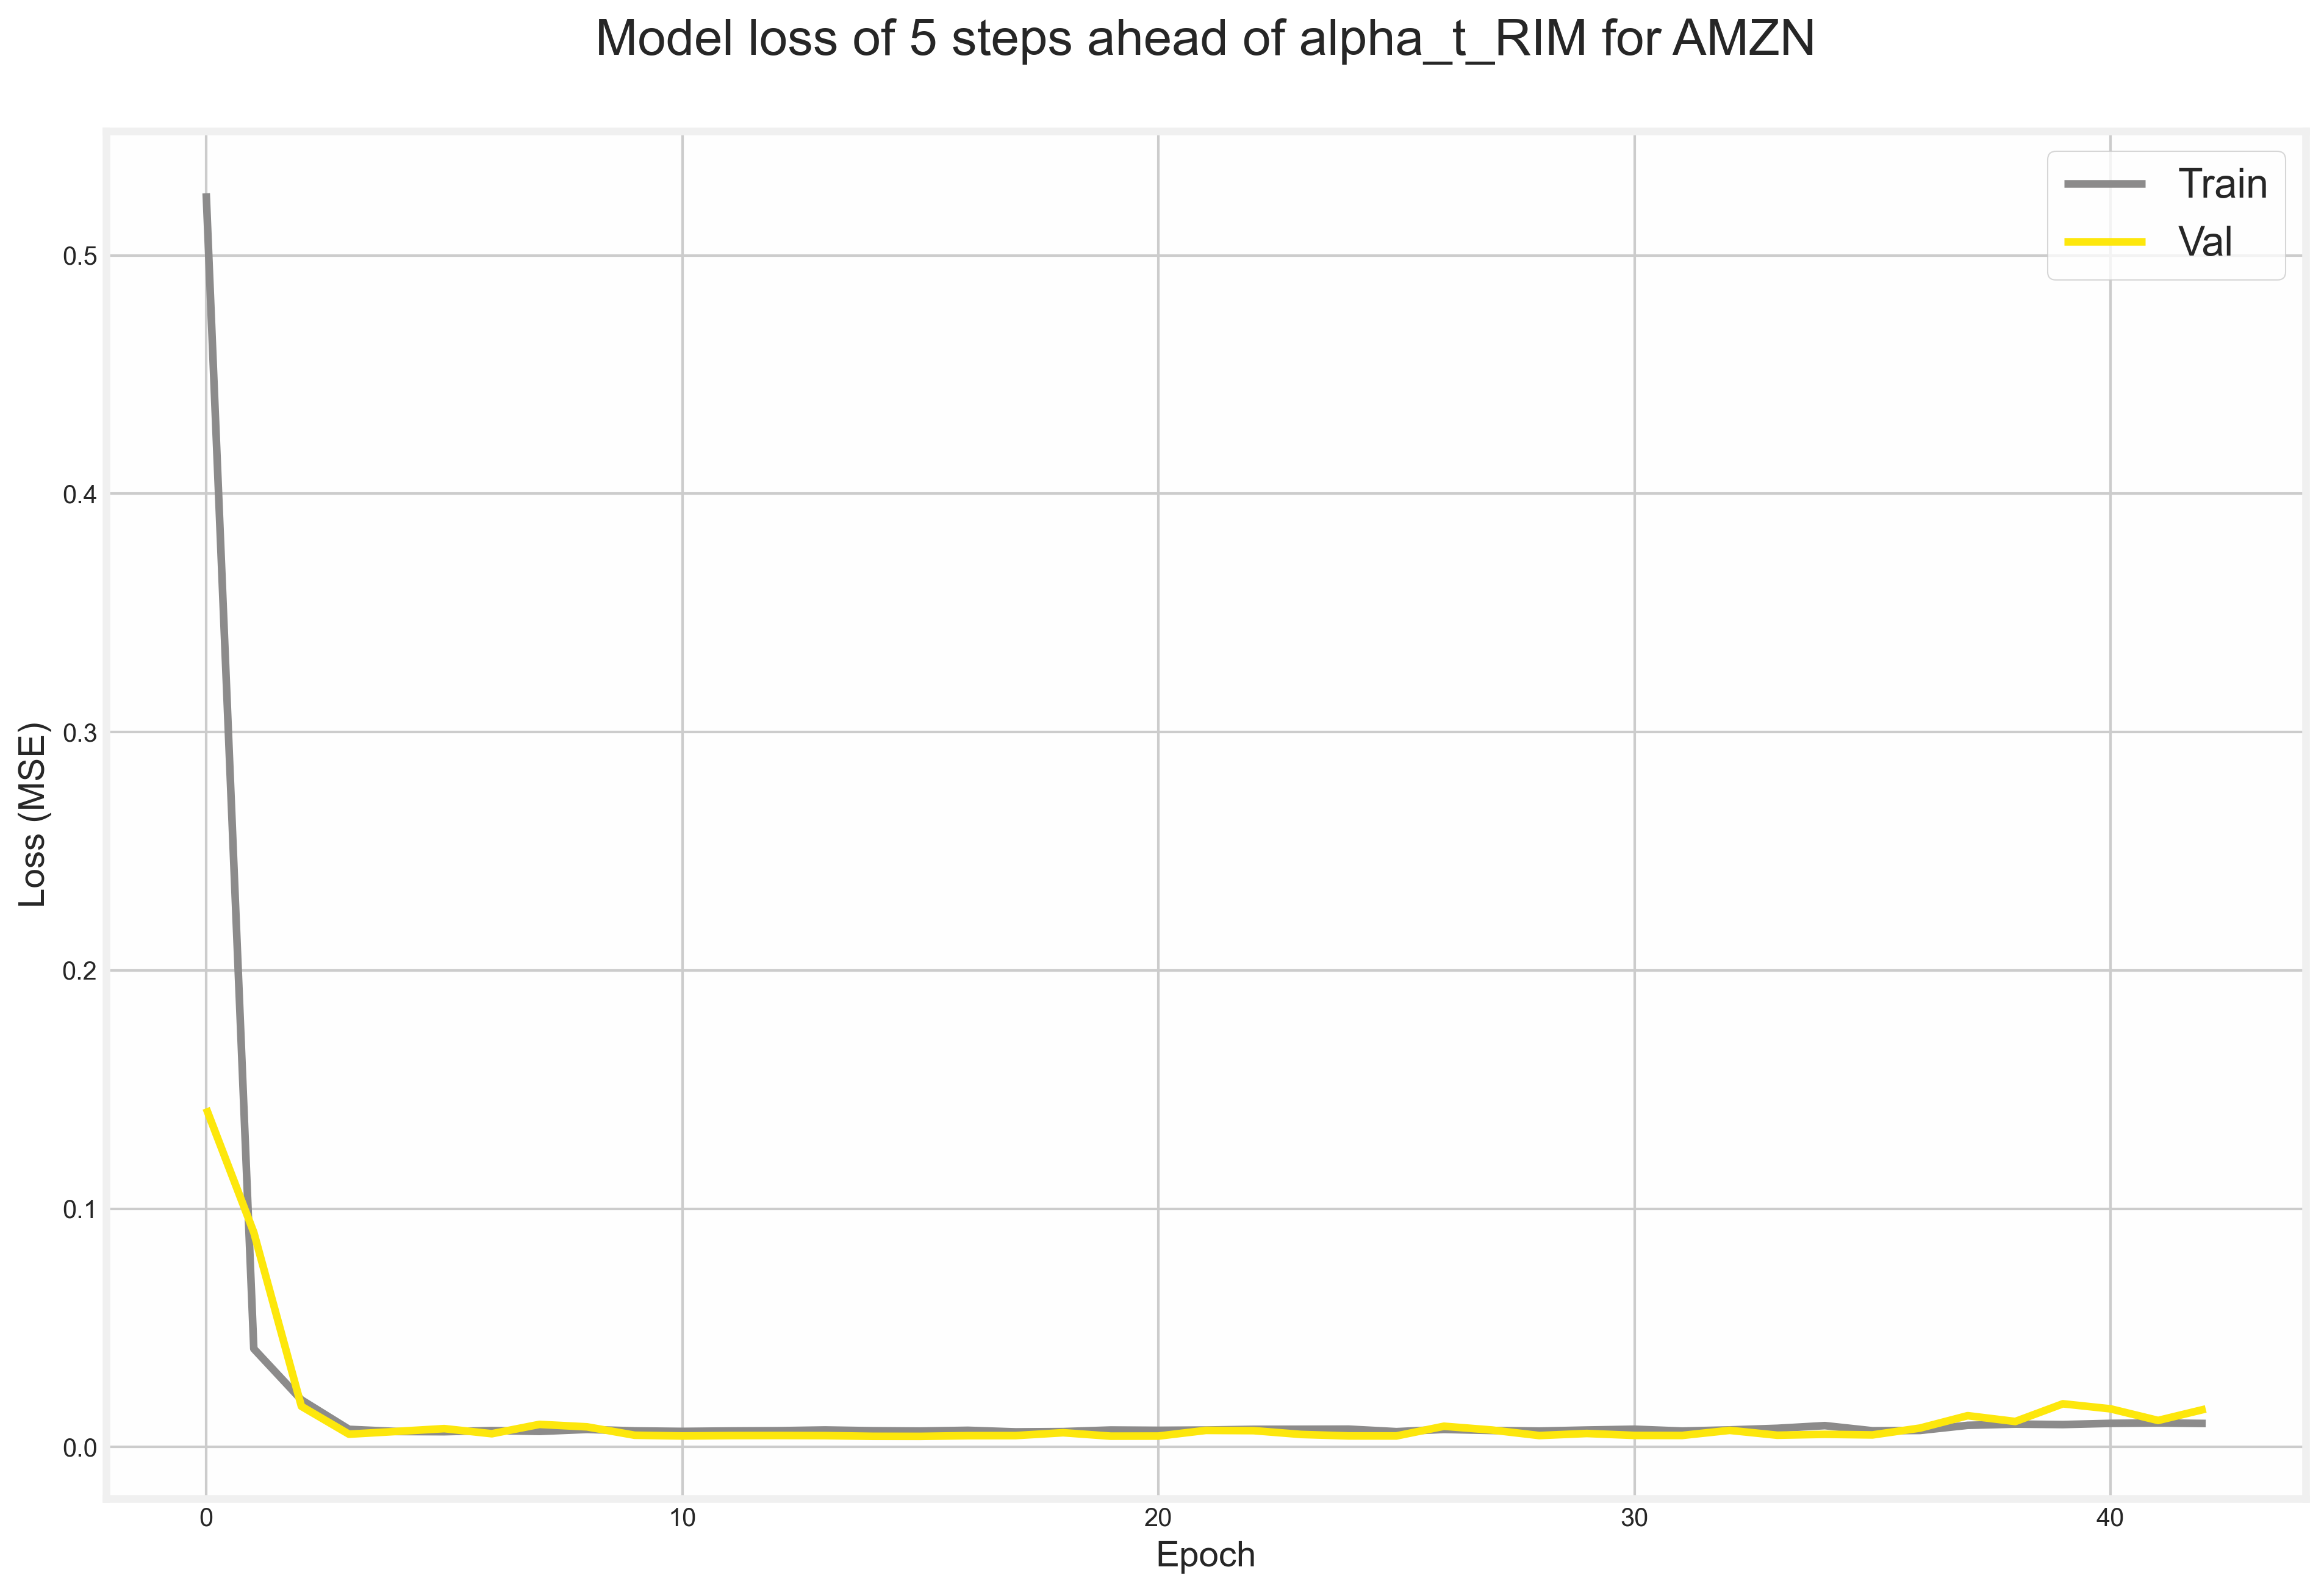

In [27]:
for key in params.keys():
    history = np.load(PATH + hist_folder + history_name +
                      '.npy', allow_pickle='TRUE').item()

    plotting.plot_train_val_loss(
        history, key, ticker, n_steps, n_steps_ahead, uni)

## Prediction

In [28]:
y_test = y_test.reshape(-1, n_steps_ahead)

for key in params.keys():
    model = params[key]['model']
    model.summary()

    params[key]['pred_train'] = model.predict(x_train, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_train steps ahead: ' + str(i+1)] = mean_squared_error(y_train[:, i],
                                                                               params[key]['pred_train'][:, i])
    params[key]['pred_val'] = model.predict(x_val, verbose=True)    

    params[key]['pred_test'] = model.predict(x_test, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_test steps ahead:' +
                    str(i+1)] = mean_squared_error(y_test[:, i], params[key]['pred_test'][:, i])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 192)               58776     
                                                                 
 dense (Dense)               (None, 5)                 965       
                                                                 
Total params: 59,741
Trainable params: 59,741
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 6ms/step


In [29]:
# e.g. ['rnn', 'alpharnn'] or ['lstm']
compare = params.keys() 

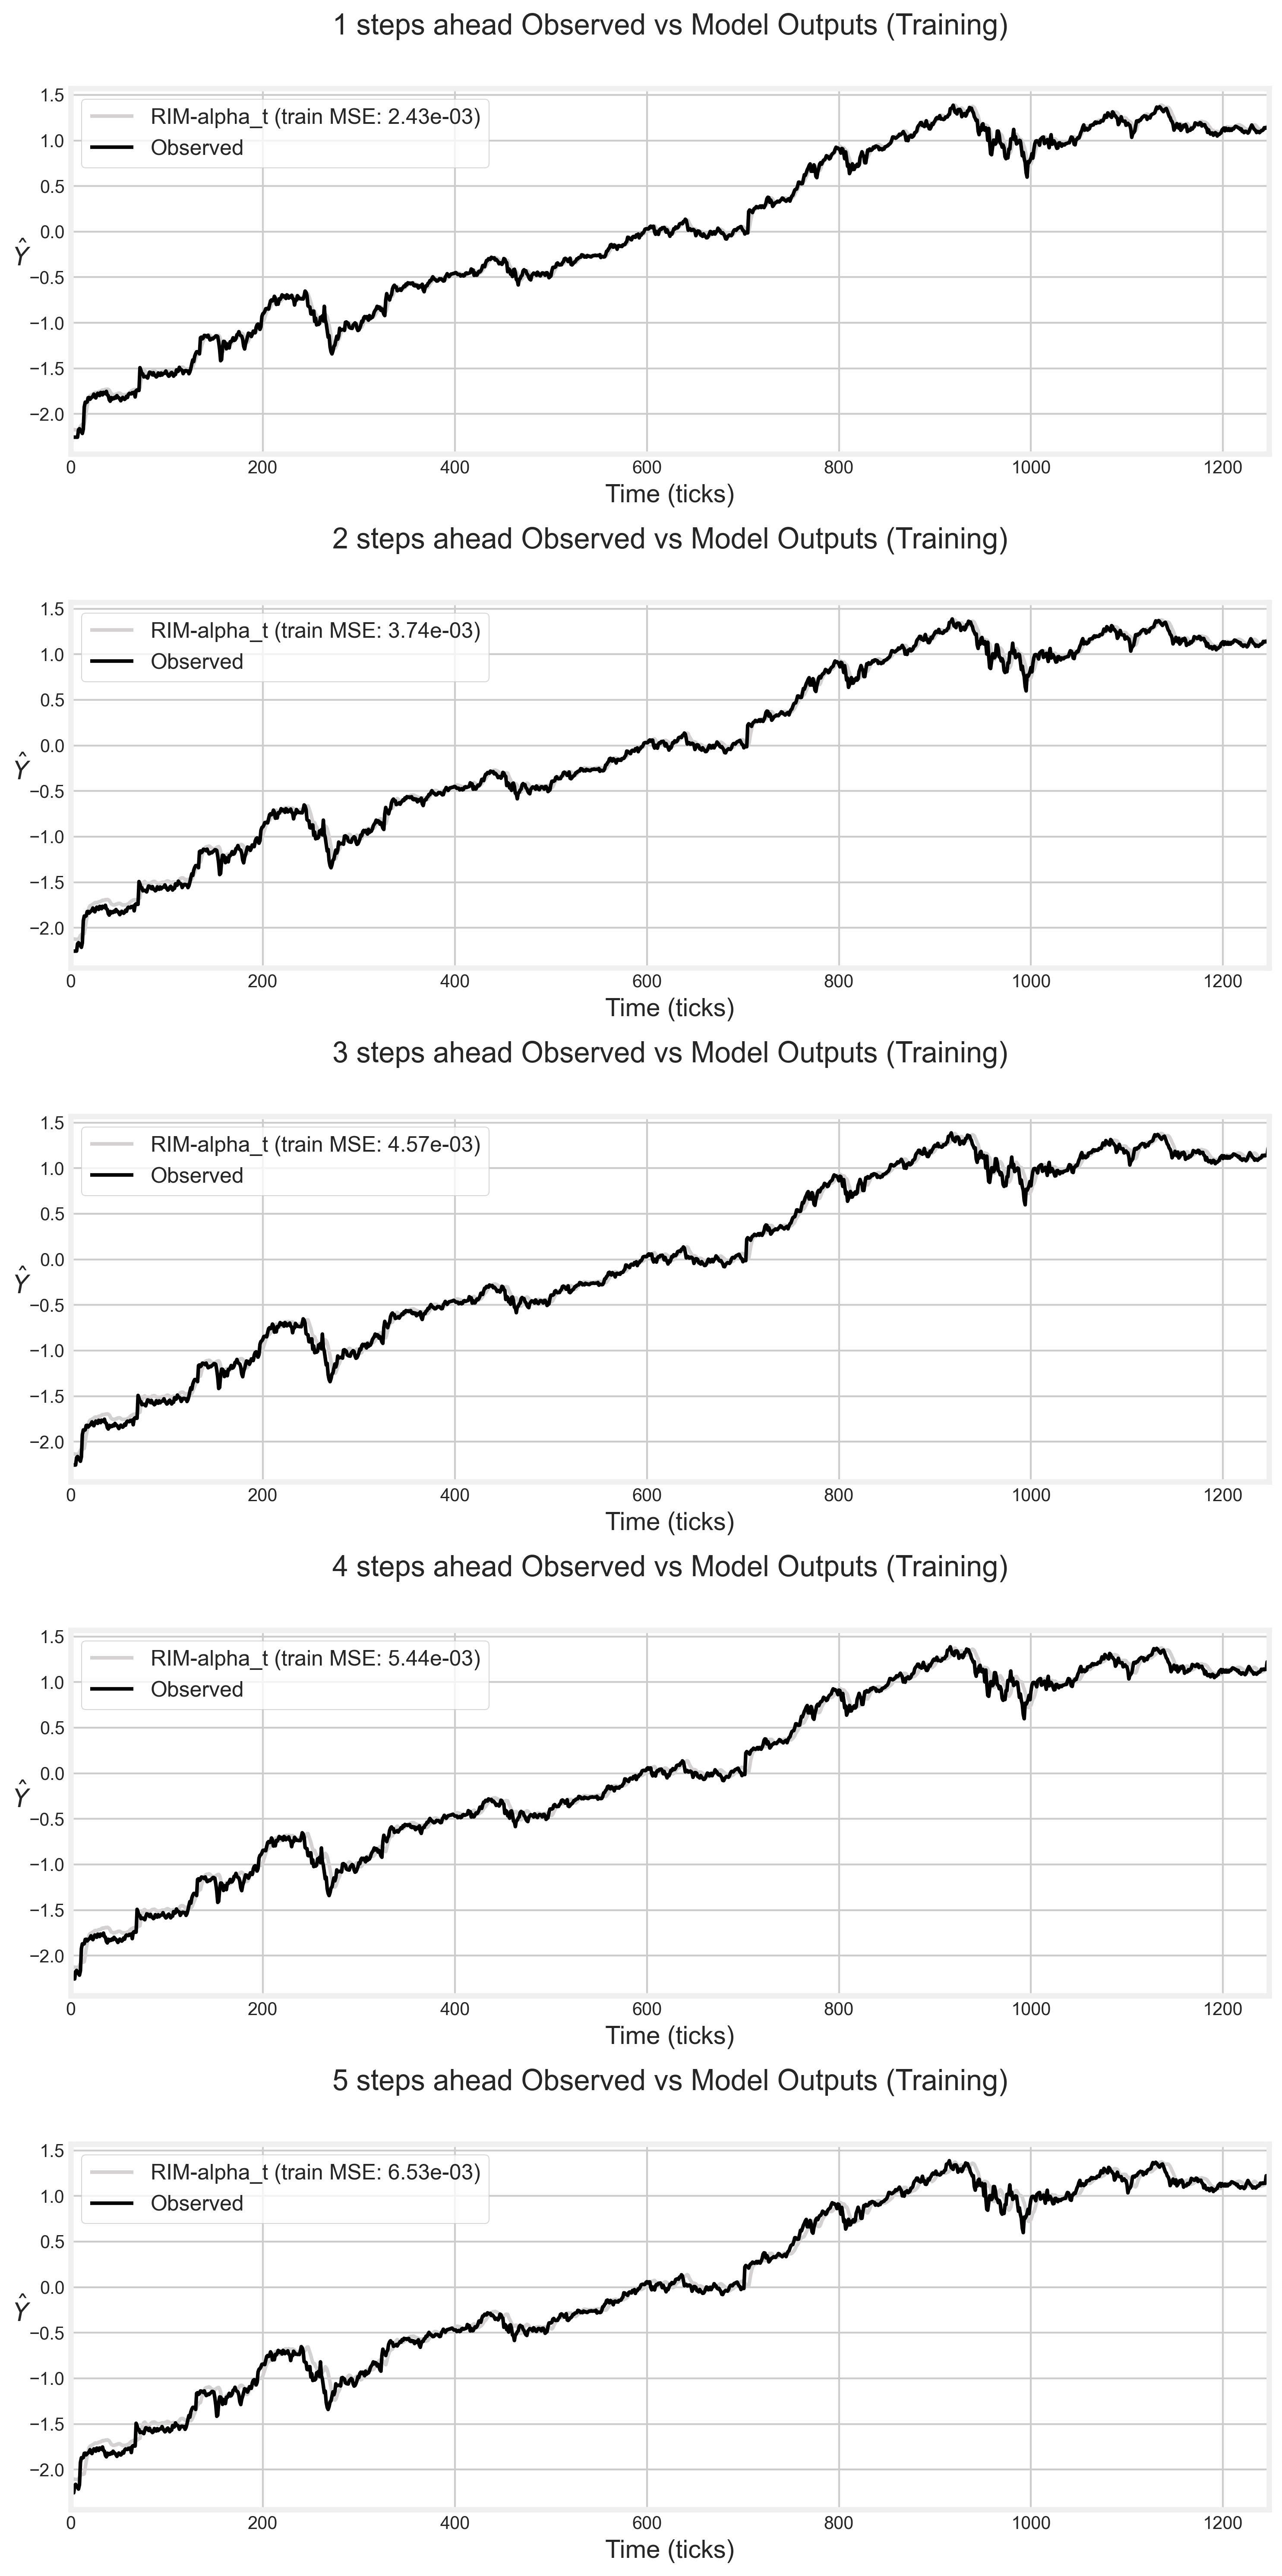

In [30]:
title_train = ' steps ahead Observed vs Model Outputs (Training)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

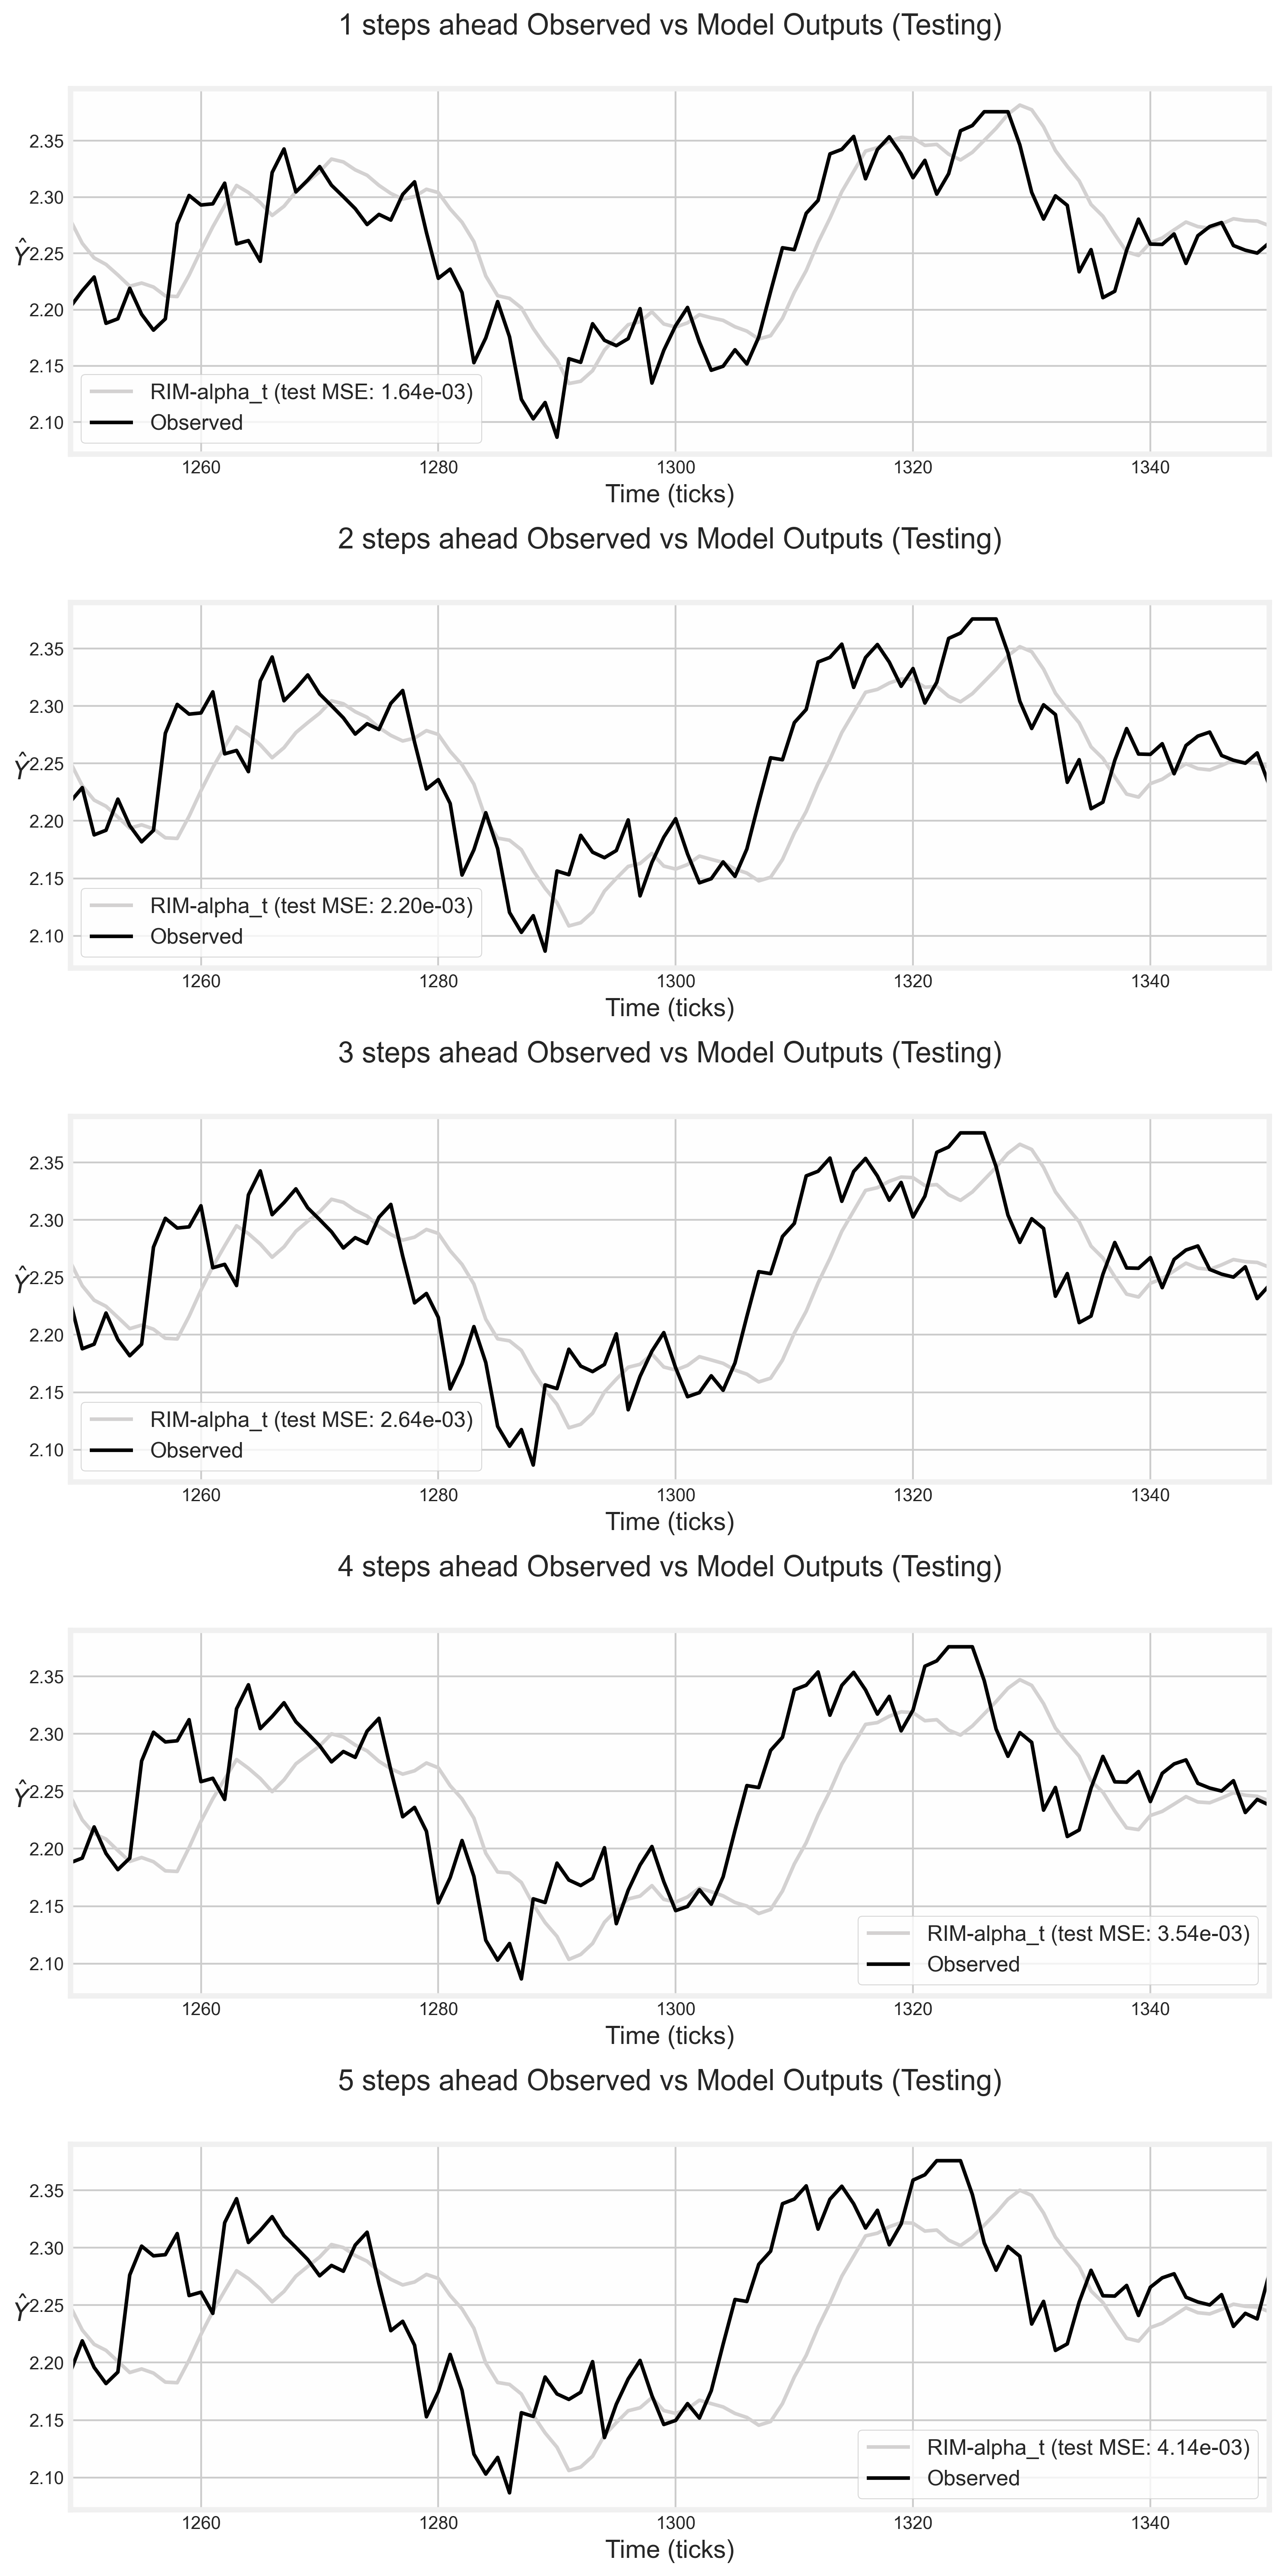

In [31]:
title_test = ' steps ahead Observed vs Model Outputs (Testing)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

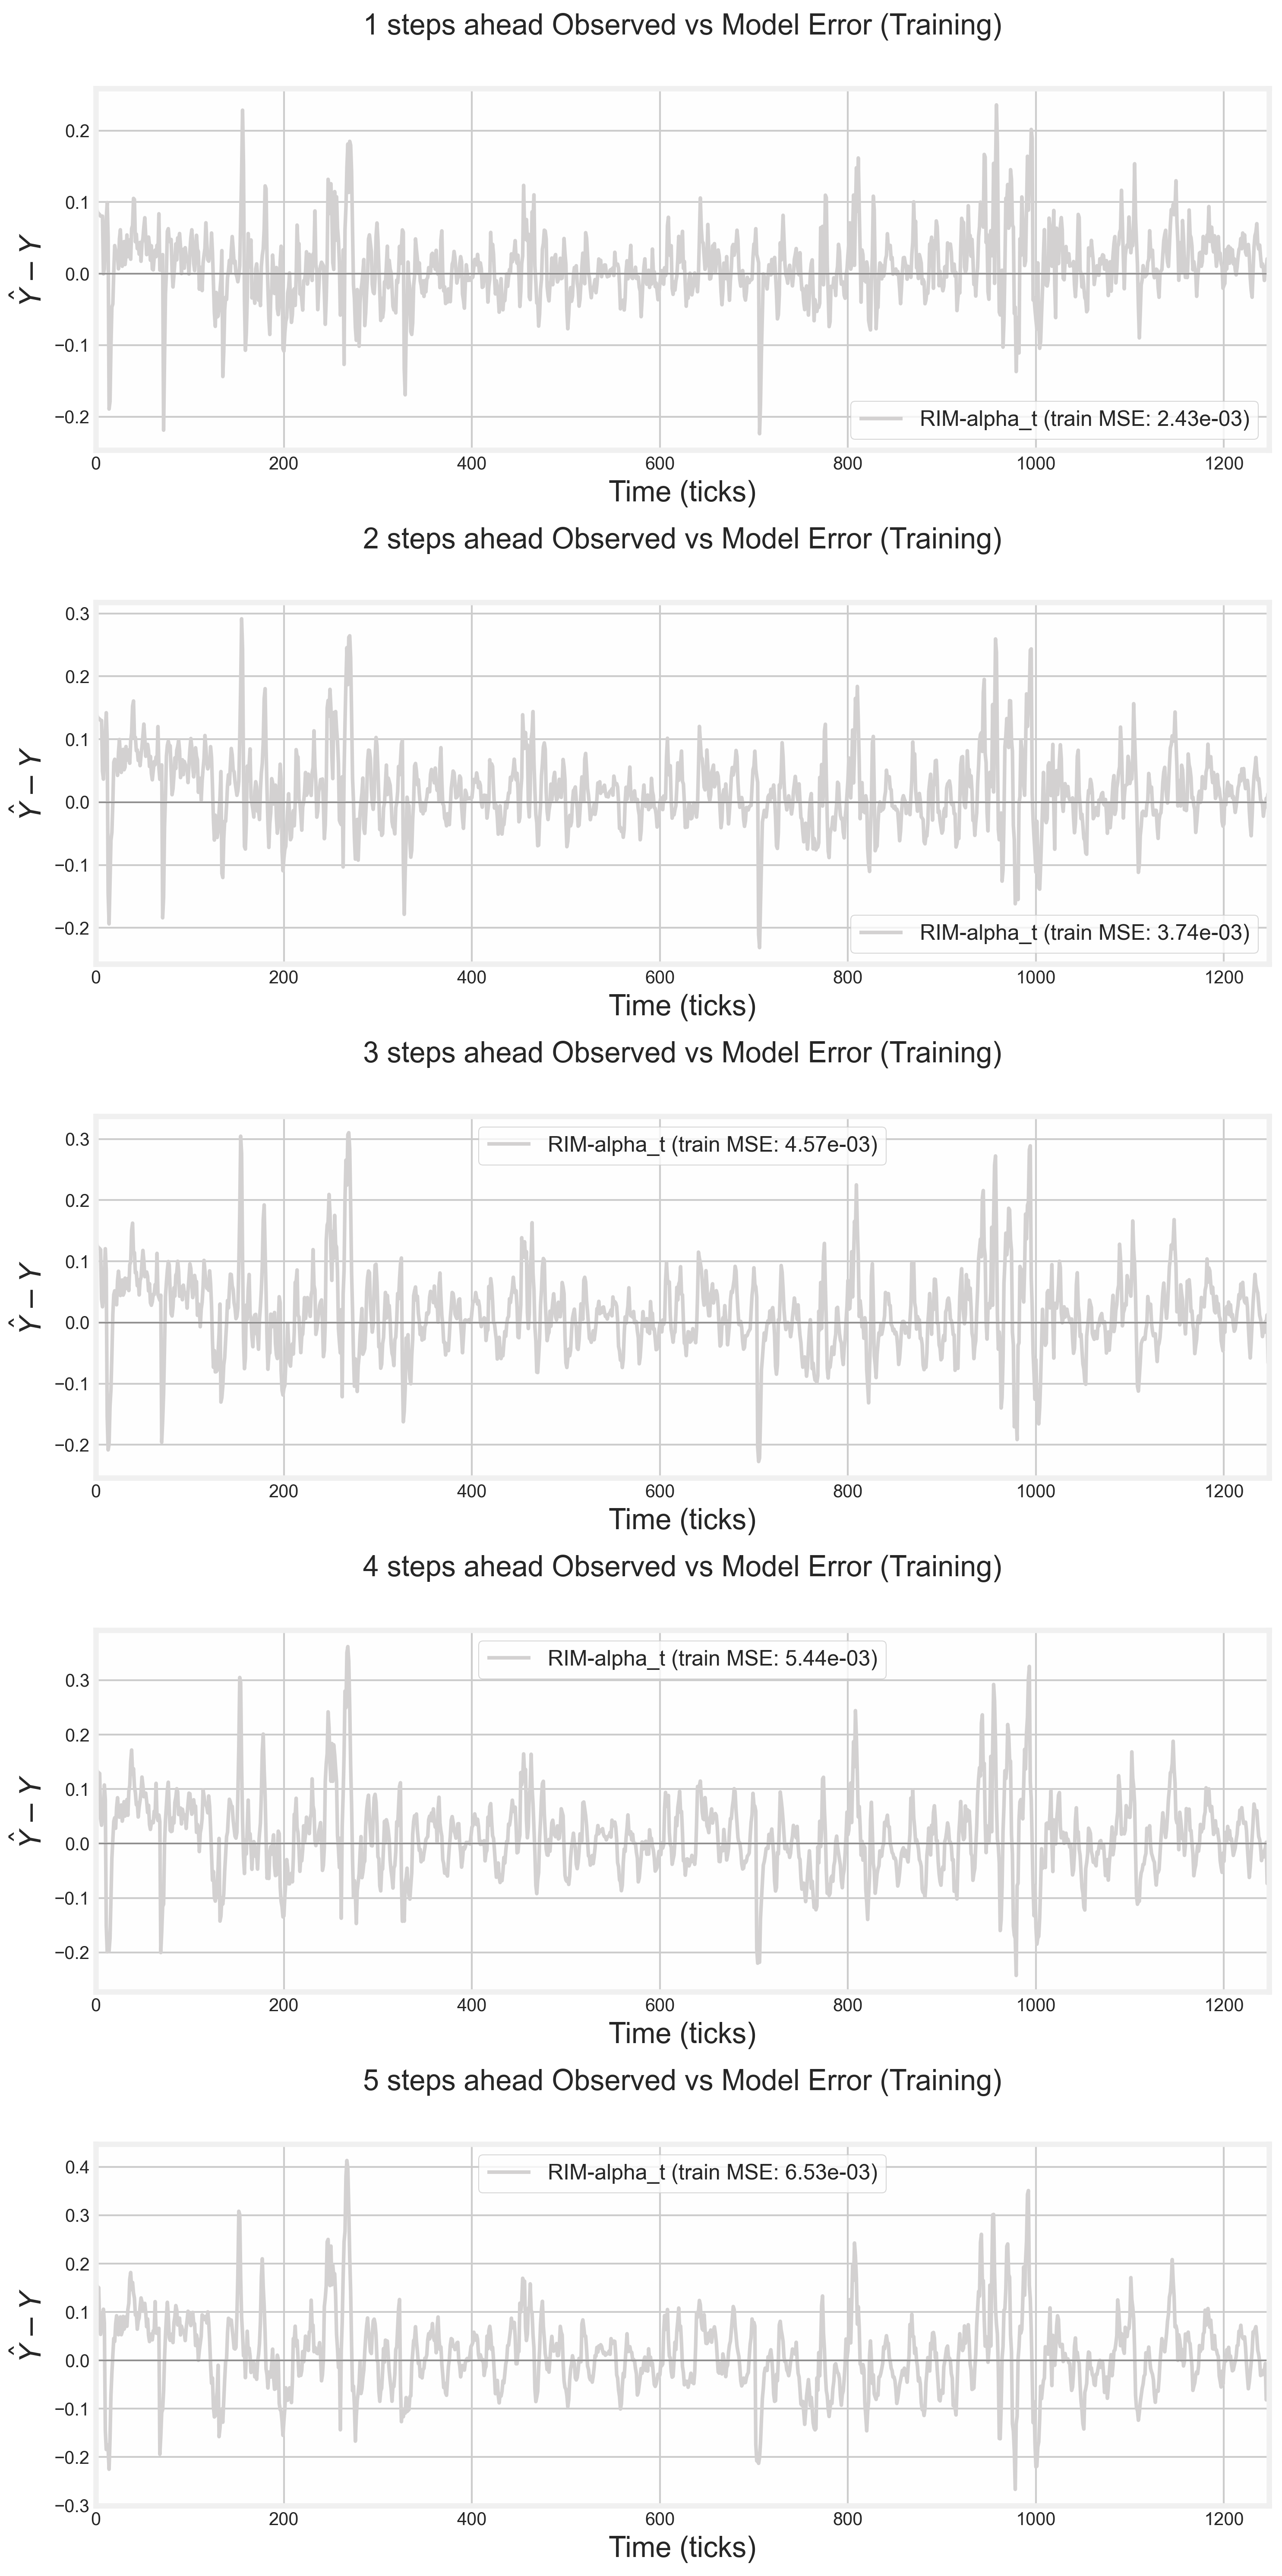

In [32]:
title_train = 'steps ahead Observed vs Model Error (Training)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

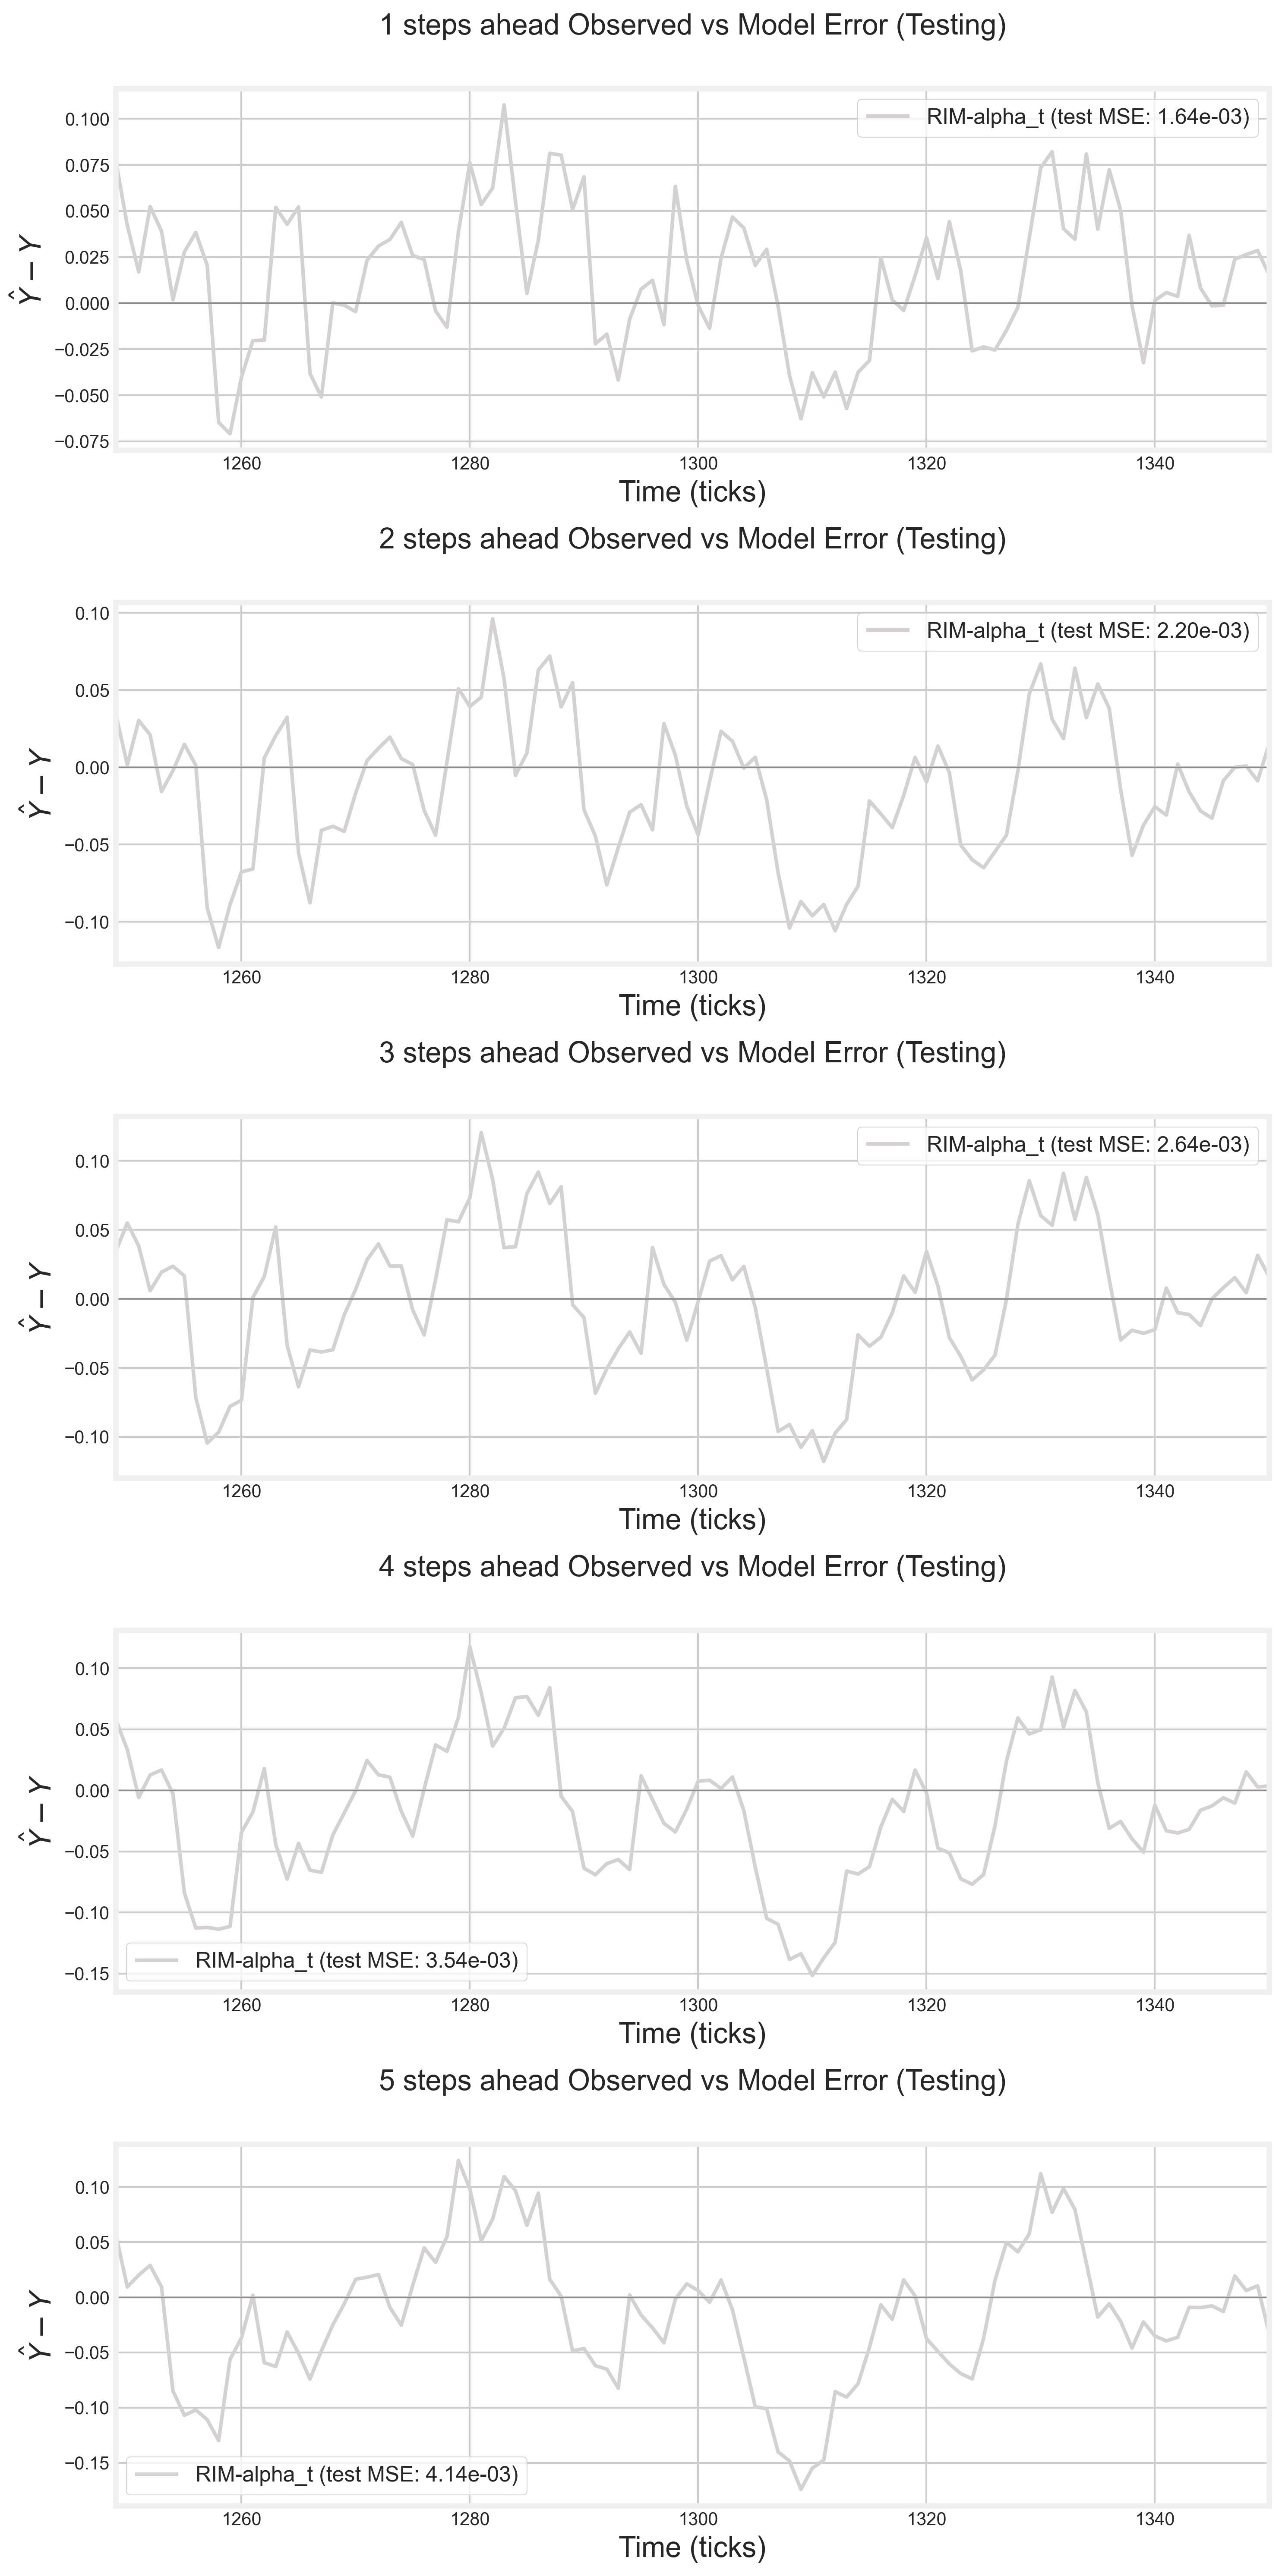

In [33]:
title_test = 'steps ahead Observed vs Model Error (Testing)'
plotting.error_plot_timeline(compare, params, n_steps_ahead, y_train,
                    y_test, title=title_test, trainplot=False)

[0.653574116719129, 0.5337807495822426, 0.43911764492235406, 0.24909193834447296, 0.11465561695998117]


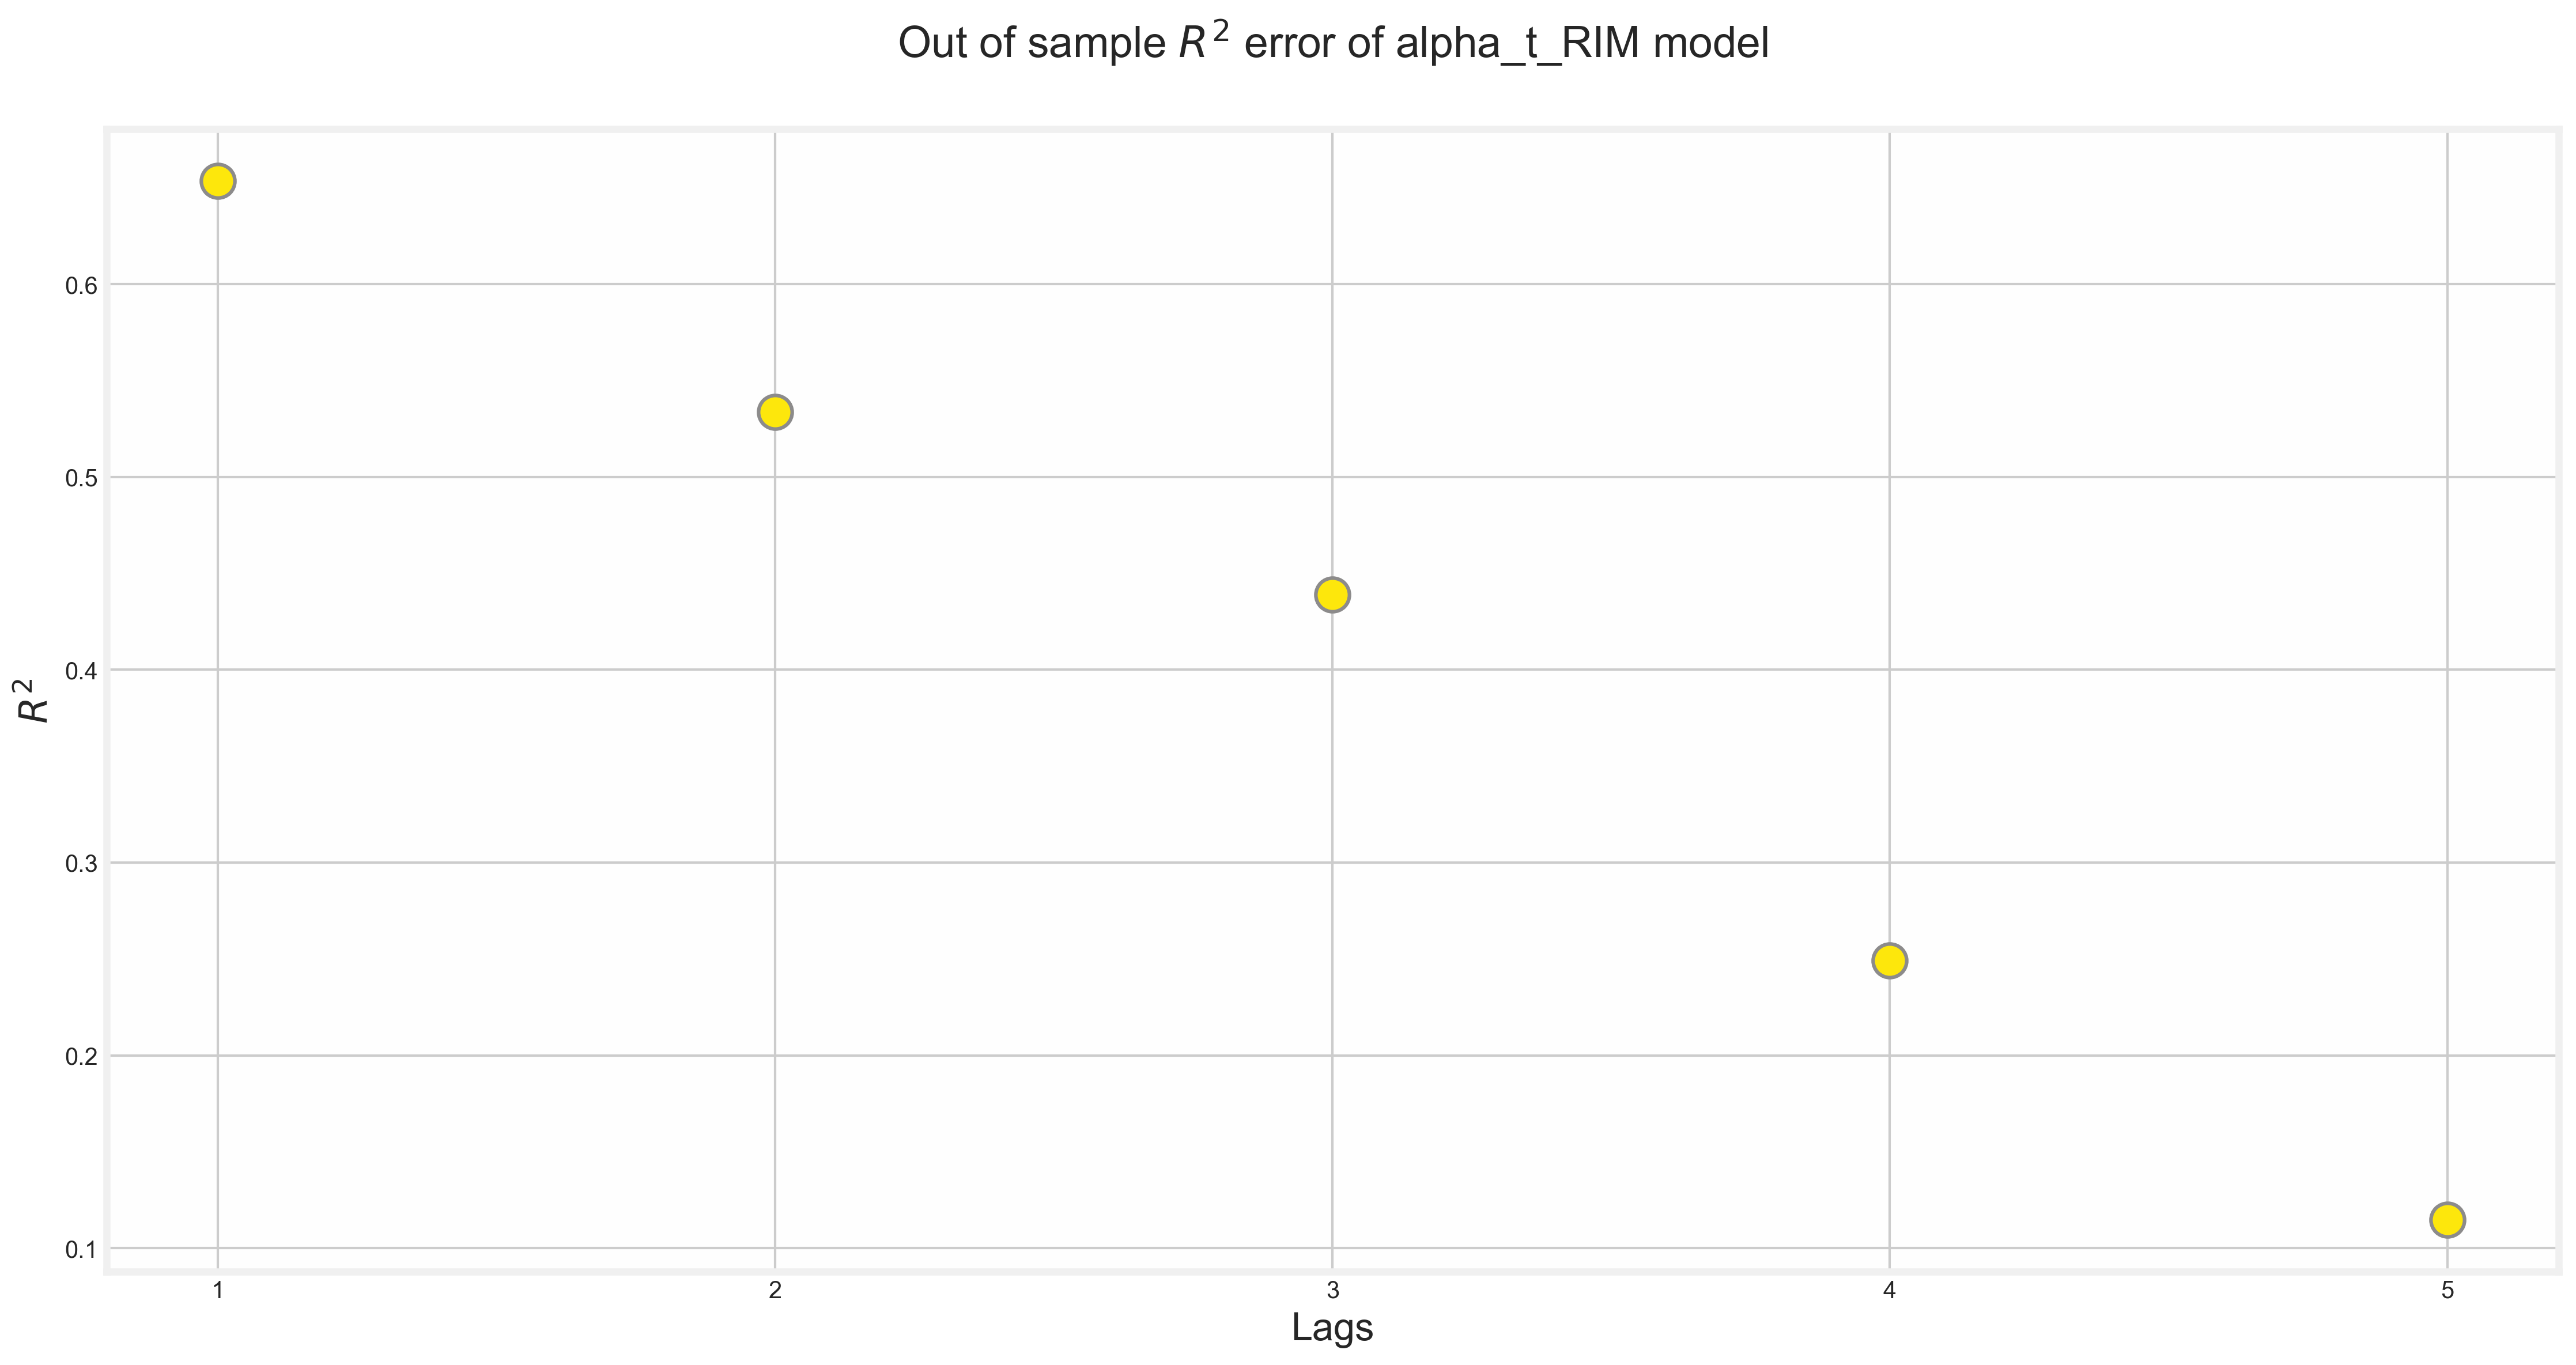

In [34]:
for key in compare:
    plt.figure(figsize=(15, 8))
    title = 'Out of sample $R^2$ error of ' + key + ' model'
    plotting.r2_error_plot(
        y_test, params[key]['pred_test'], n_steps_ahead, title)

[0.0016433844689607965, 0.00220254932862487, 0.0026435113831284386, 0.0035366954409942054, 0.004139153576716569]


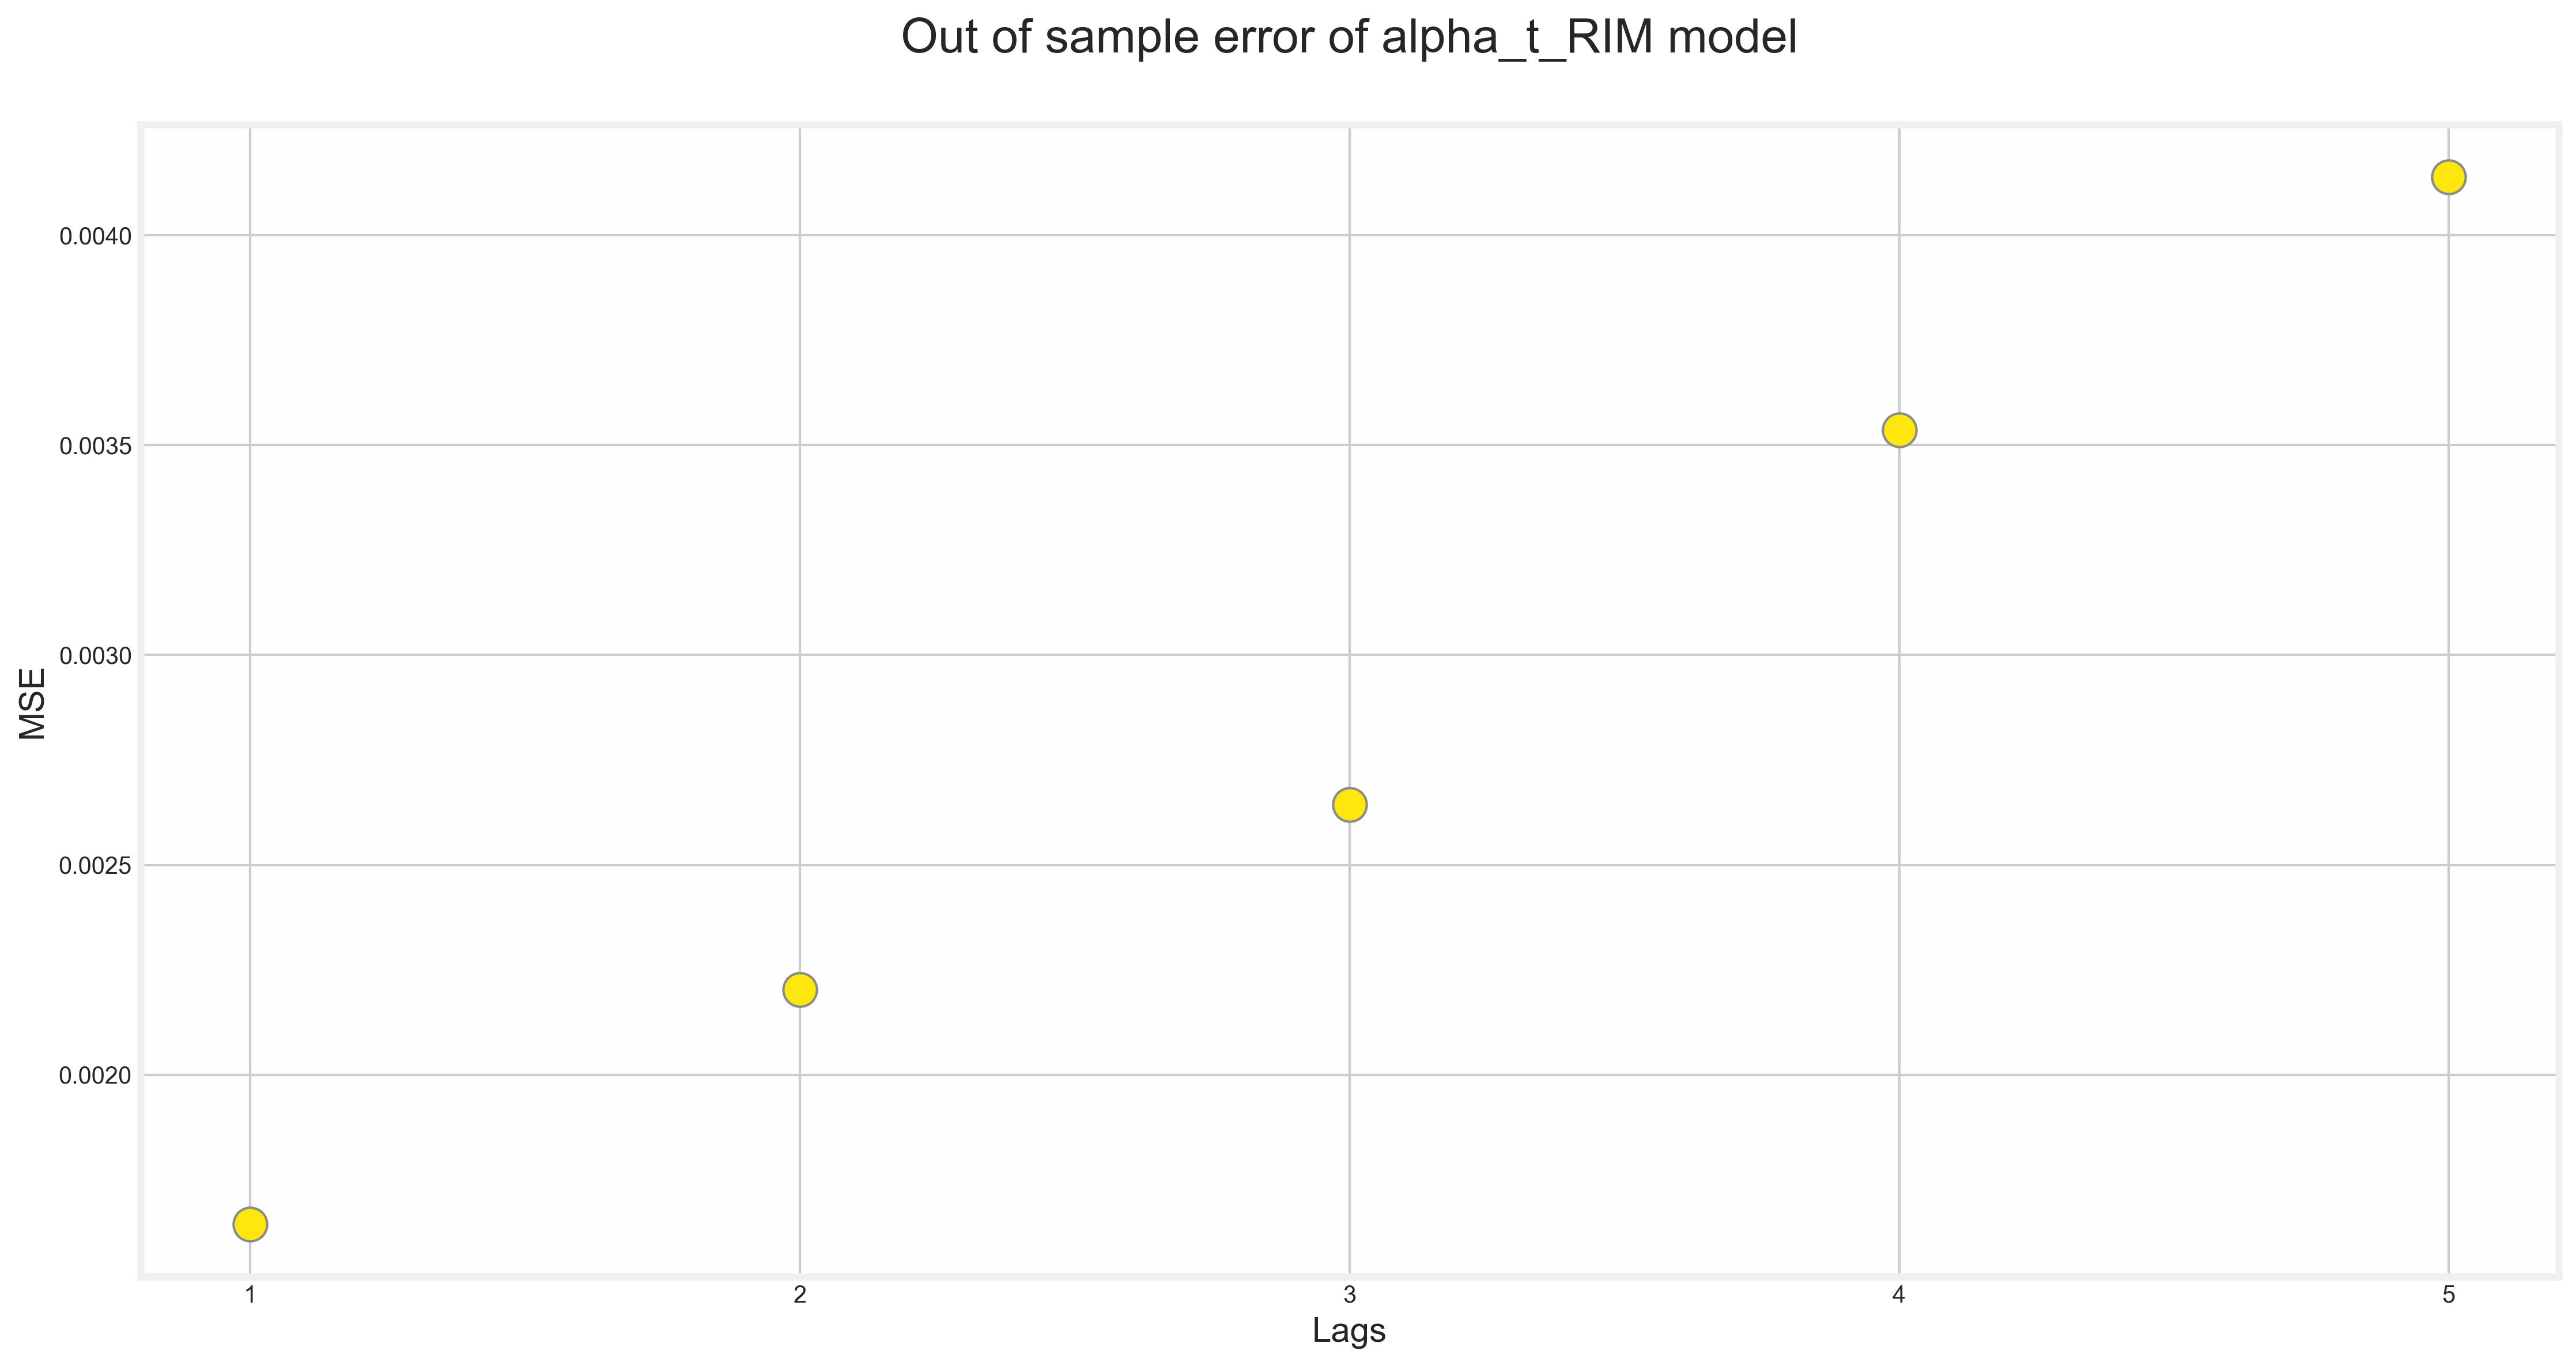

In [35]:
for key in compare:
    plt.figure(figsize=(15, 8))
    title = 'Out of sample error of ' + key + ' model'
    plotting.error_plot(y_test, params[key]['pred_test'], n_steps_ahead, title)

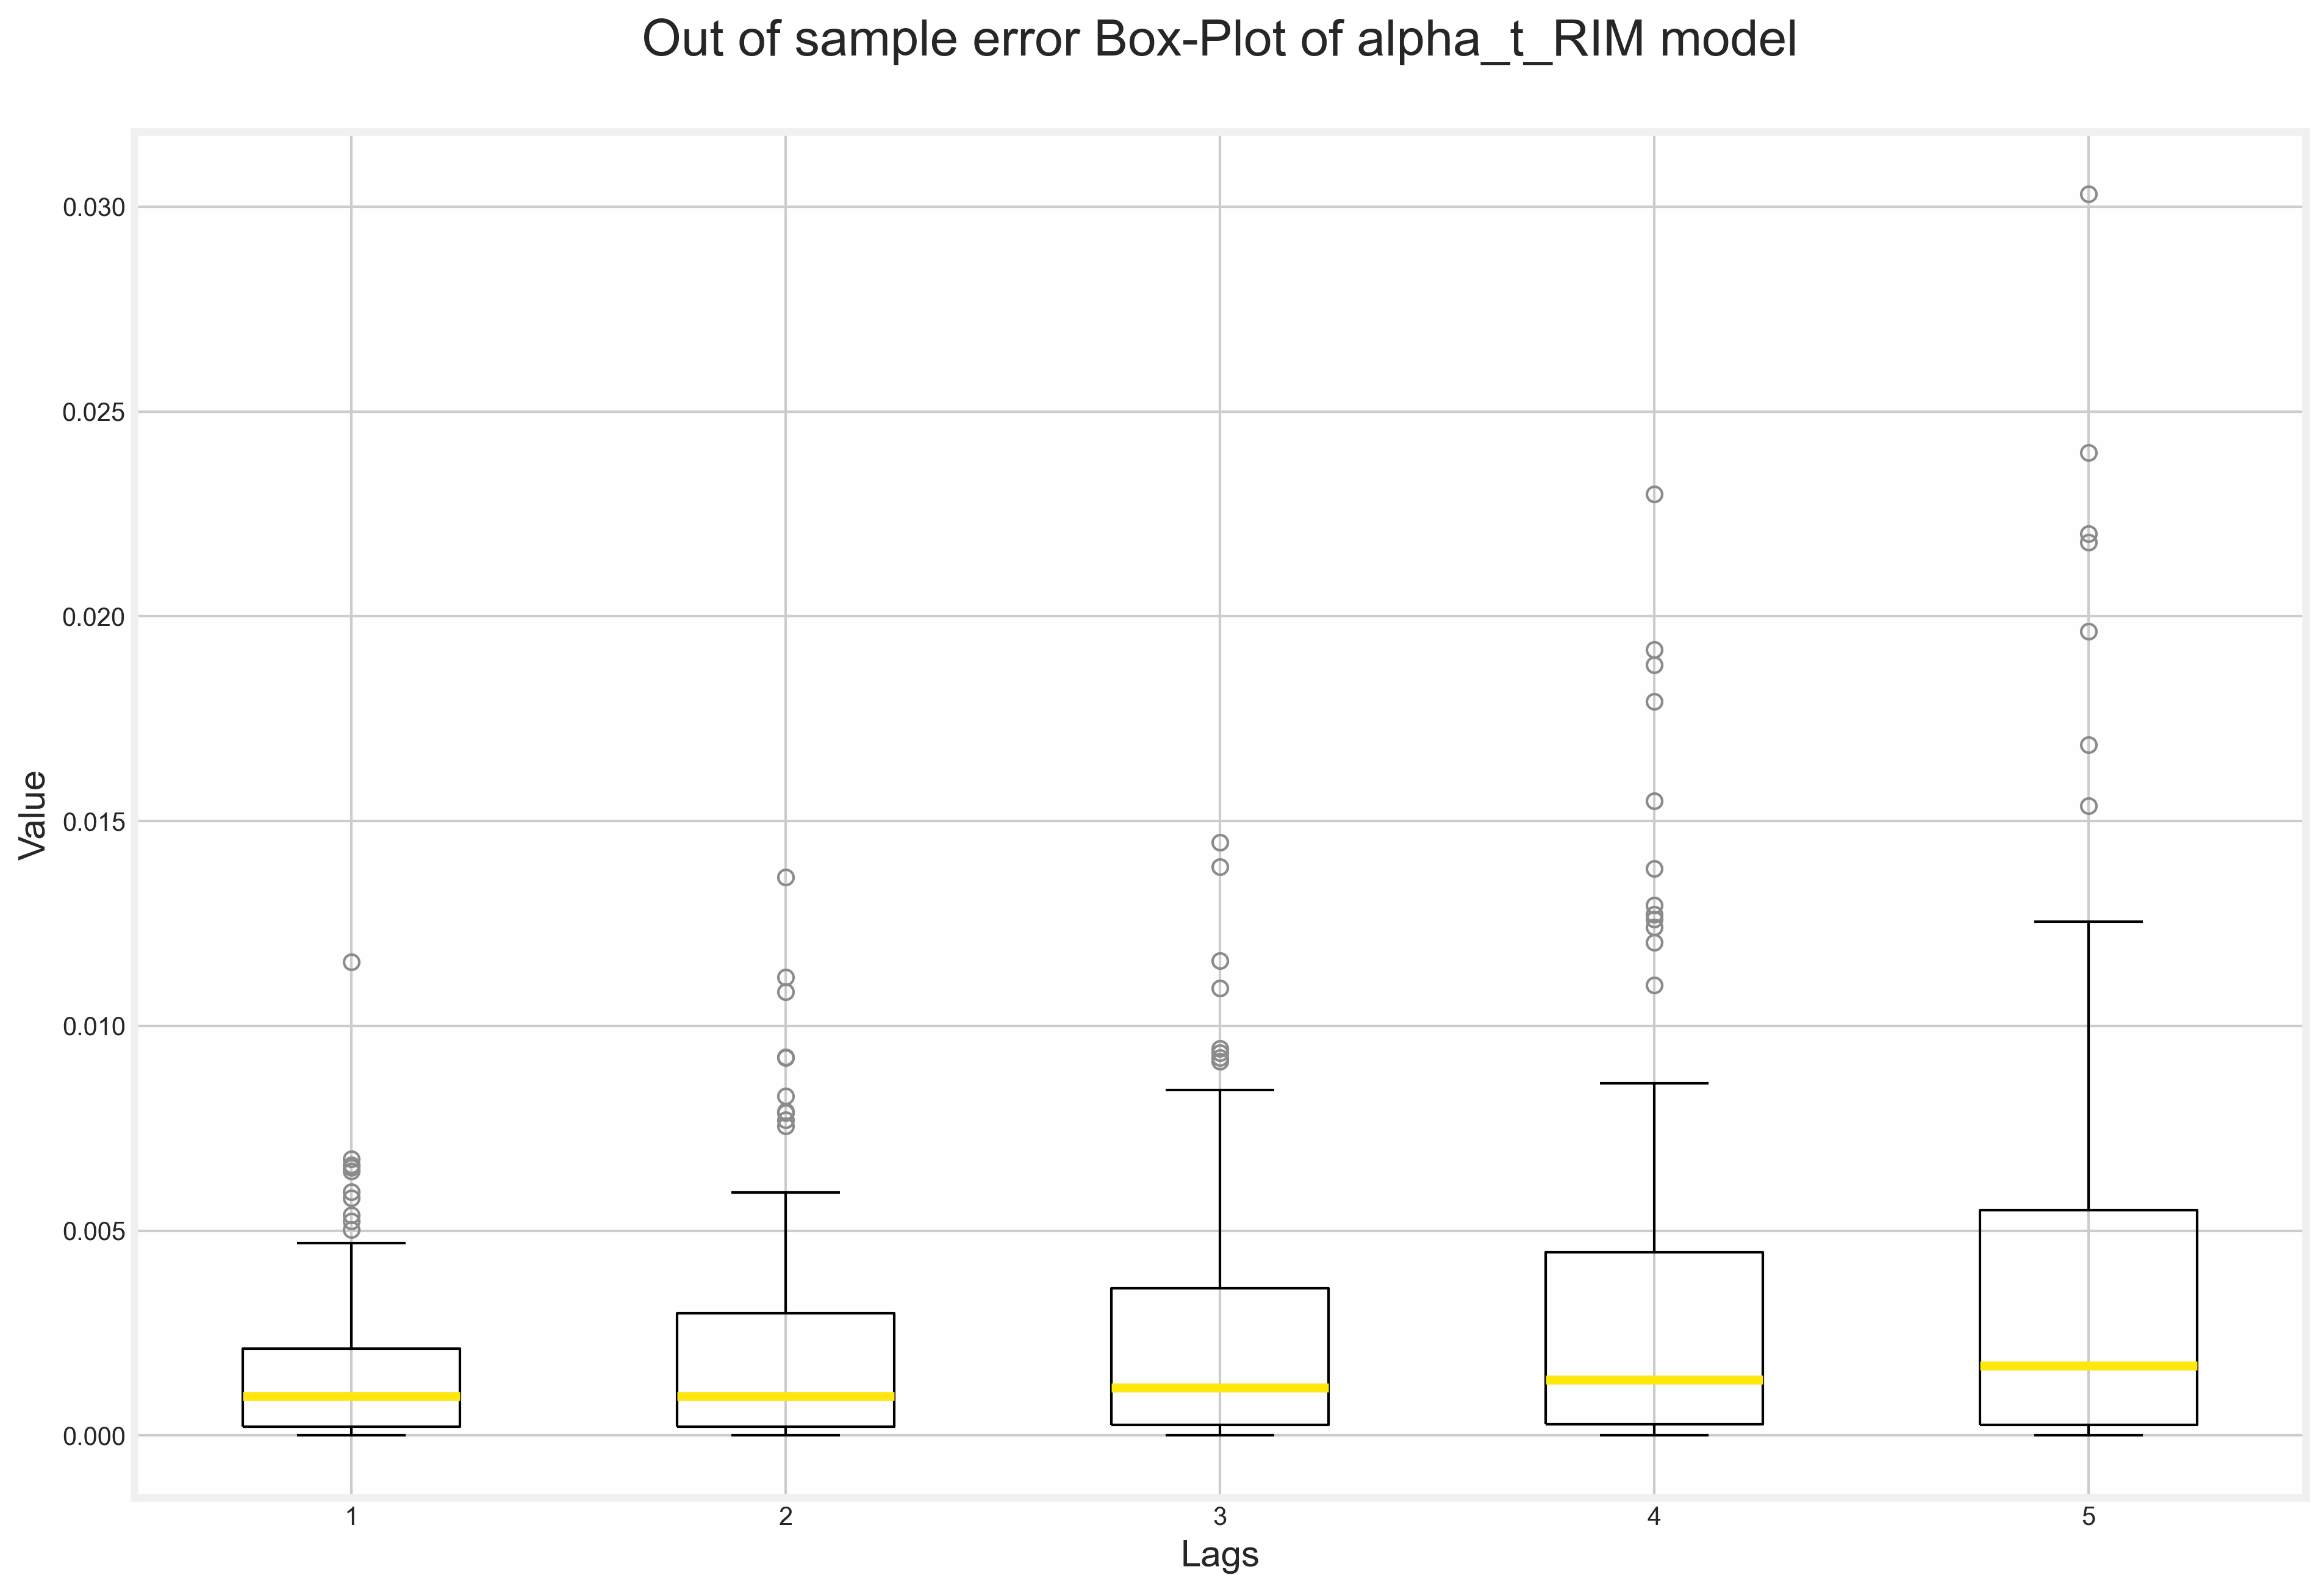

In [36]:
for key in compare:
    title = 'Out of sample error Box-Plot of ' + key + ' model'
    plotting.error_boxplot(
        y_test, params[key]['pred_test'], n_steps_ahead, title)

# Model Diagnostics

## Evaluate model

To gain more insights about the overall performance of the model, we use tensorflow's `evaluate()` function. 

In [37]:
# store the model performance
model_performance = {}

lags = str(n_steps)

# init the names
if uni:
    performance_name_train = key + '_' + ticker + '_' + lags + '_train_price'
    performance_name_val = key + '_' + ticker + '_' + lags + '_val_price'
    performance_name_test = key + '_' + ticker + '_' + lags + '_test_price'

else:
    performance_name_train = key + '_' + ticker + '_' + lags + '_train_conv_price'
    performance_name_val = key + '_' + ticker + '_' + lags + '_val_conv_price'
    performance_name_test = key + '_' + ticker + '_' + lags + '_test_conv_price'

# eval the model
for key in params.keys():
    model = params[key]['model']
    
    model_performance[performance_name_train] = model.evaluate(x_train, y_train)
    model_performance[performance_name_val] = model.evaluate(x_val, y_val)
    model_performance[performance_name_test] = model.evaluate(x_test, y_test)

    
metrics_evaluate = ma.get_eval_df(model_performance)
metrics_evaluate

4/4 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0416


MSE        MAE
alpha_t_RIM_AMZN_5_train_price 0.00454009 0.04843006
alpha_t_RIM_AMZN_5_val_price   0.00480371 0.05362472
alpha_t_RIM_AMZN_5_test_price  0.00283306 0.04159042

In [38]:
# save the date frame
evaluate_path = '../model_evaluate/'
evaluate_folder = '{}/'.format(ticker)

if uni: 
    evaluate_file_name = '_evaluate_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)

else: 
    evaluate_file_name = '_evaluate_df-price_conv-{}-{}-n_steps.csv'.format(ticker, n_steps)


metrics_evaluate.to_csv(evaluate_path + evaluate_folder + key + evaluate_file_name)

## Grid search

In [39]:
# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

In [40]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores
tscv = TimeSeriesSplit(n_splits=5)

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(tscv.split(x_train, y_train))[0][0])
n_test = len(list(tscv.split(x_train, y_train))[0][1])

t_stat, p_val = ma.compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\n"
      f"Corrected p-value: {p_val:.3f}")

Corrected t-value: -0.578
Corrected p-value: 0.311


In [41]:
t_stat_uncorrected = (
    np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
      f"Uncorrected p-value: {p_val_uncorrected:.3f}")


Uncorrected t-value: -1.000
Uncorrected p-value: 0.211


In [42]:
# intitialize random variable
t_post = t(
    df, loc=np.mean(differences),
    scale=ma.corrected_std(differences, n_train, n_test)
)

Saving figure:  post_dist_plot_price_AMZN_n_steps_5_n_steps_ahead_5


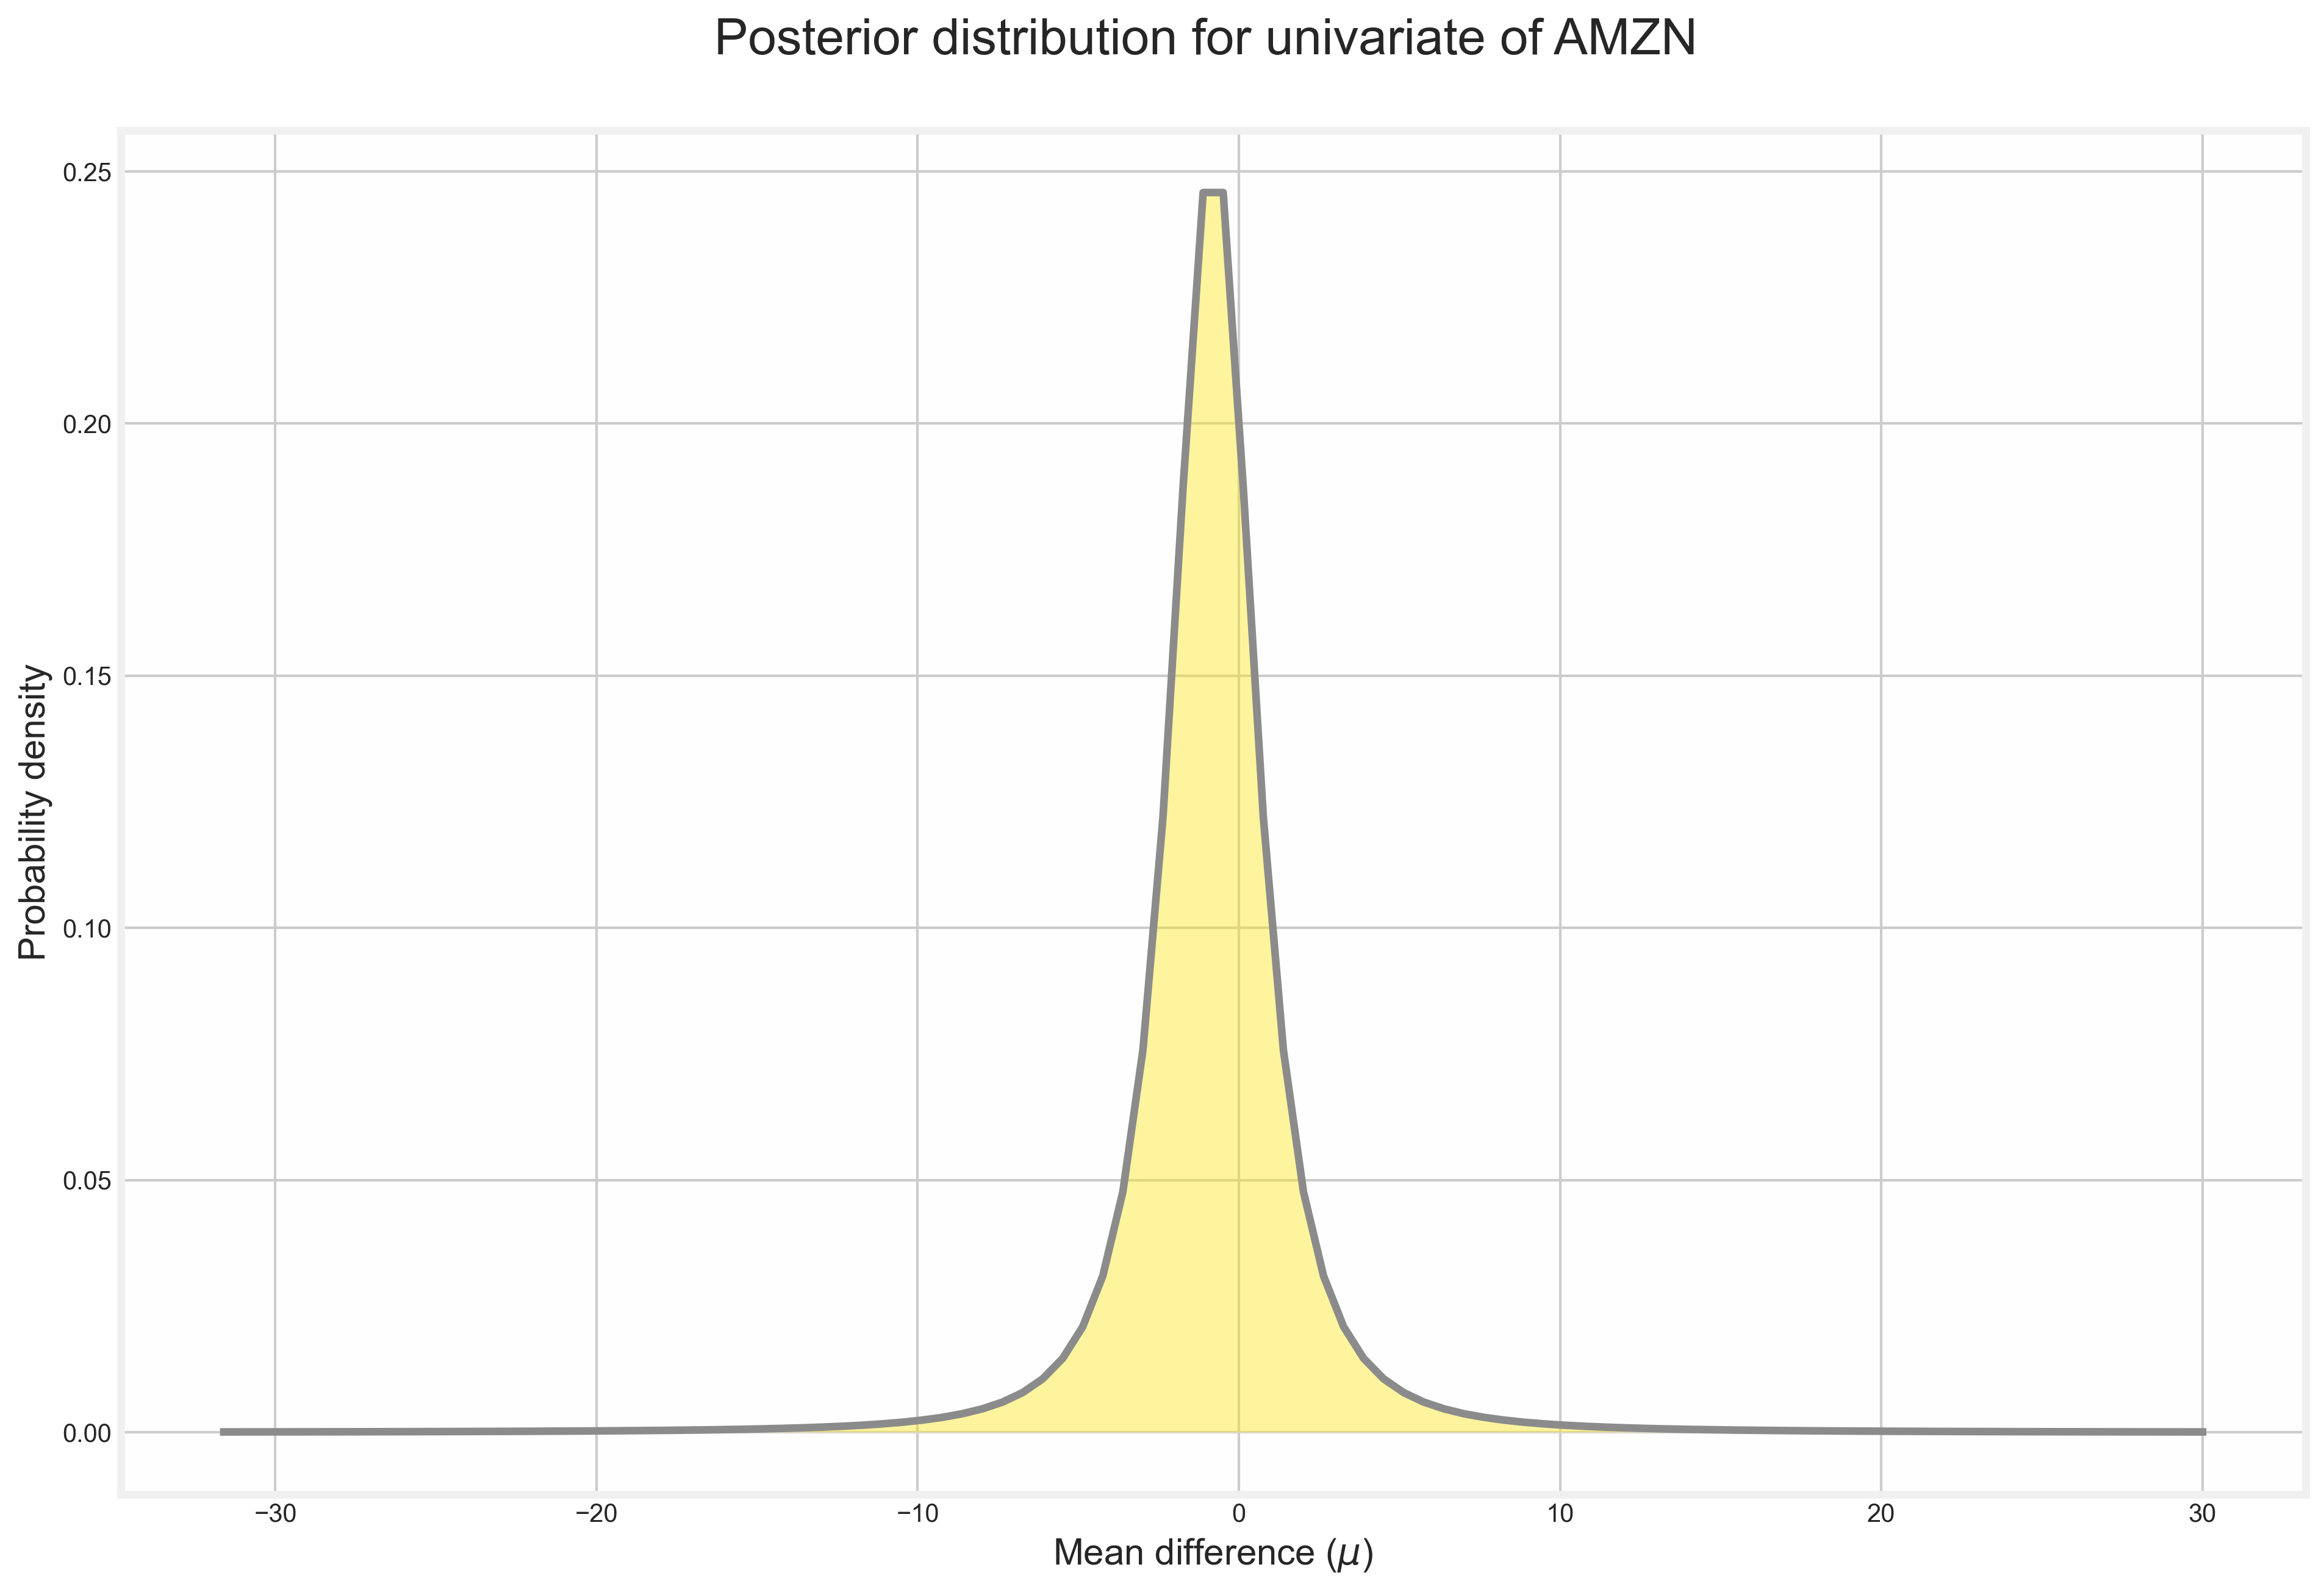

In [43]:
plotting.plot_post_distribution(t_post, ticker, n_steps, n_steps_ahead,uni)

In [44]:
better_prob = 1 - t_post.cdf(0)

print(f"Probability of model {model_scores.index[0]} being more accurate than "
      f"{model_scores.index[1]}: {better_prob:.3f}")
print(f"Probability of model {model_scores.index[1]} being more accurate than "
      f"{model_scores.index[0]}: {1 - better_prob:.3f}")

Probability of model 0 being more accurate than 1: 0.311
Probability of model 1 being more accurate than 0: 0.689


Saving figure:  Histogramm_plot_price_AMZN_n_steps_5_n_steps_ahead_5


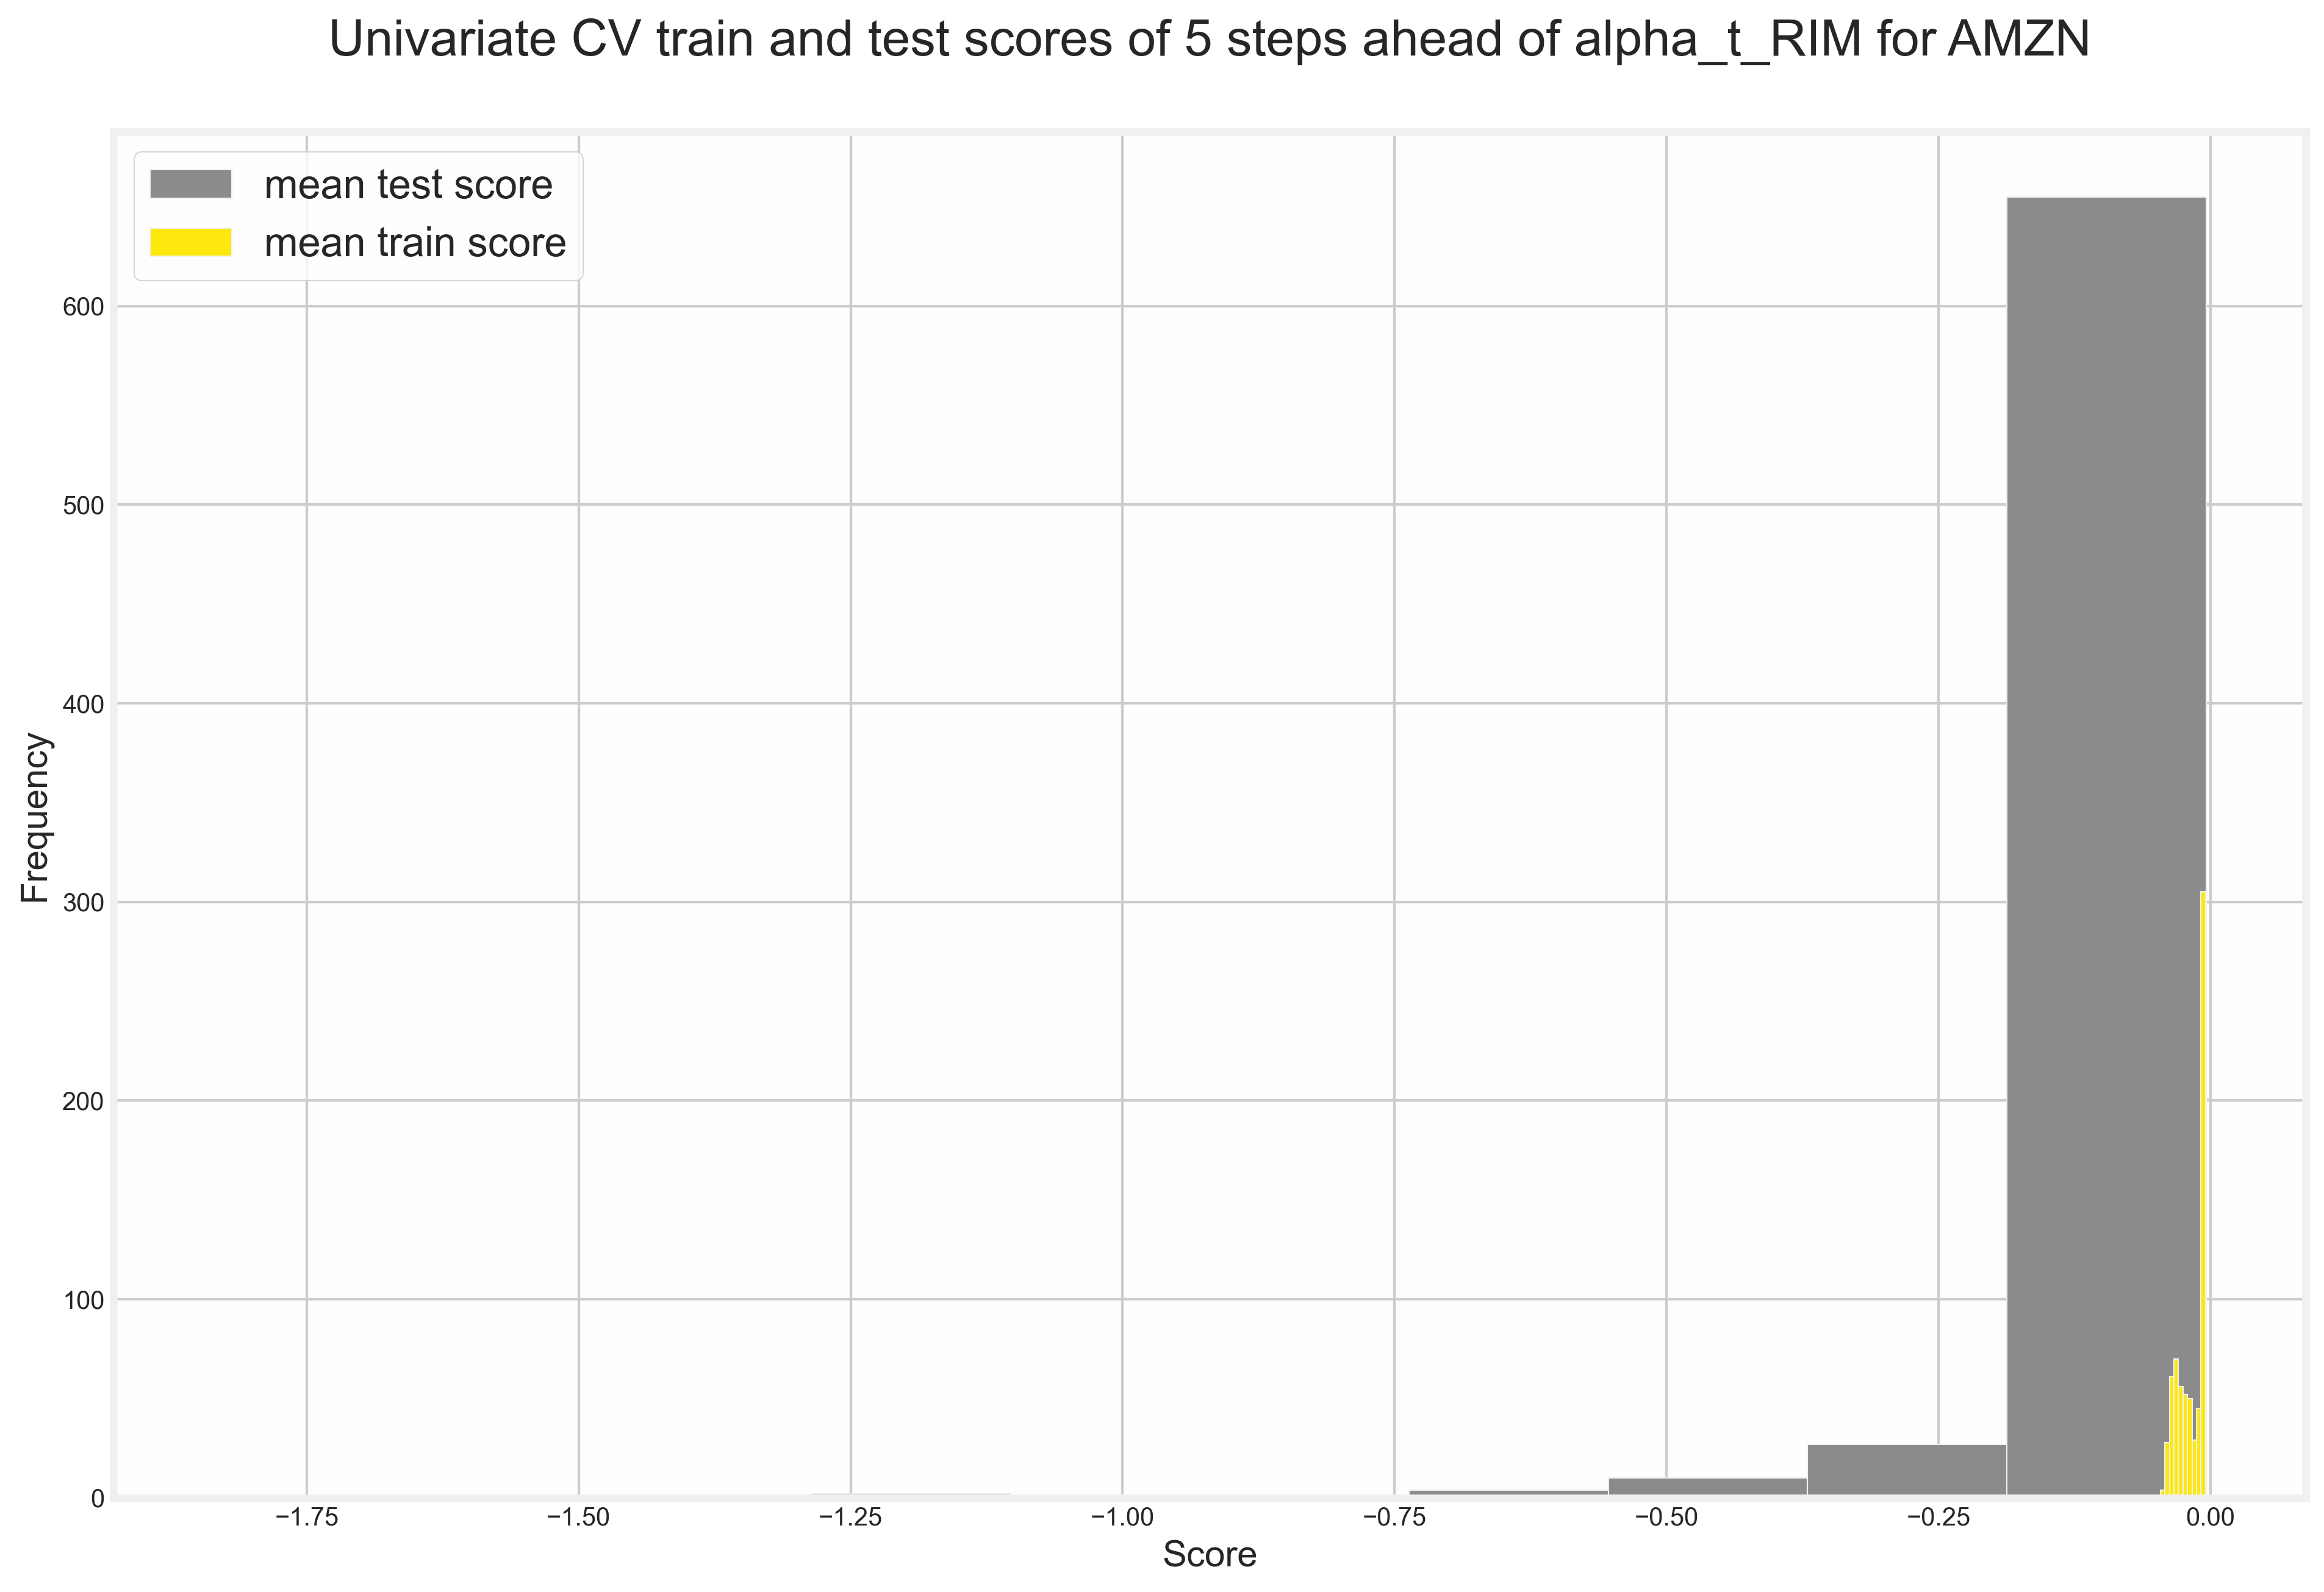

In [45]:
plotting.plot_CV_histogram(results_df, key, ticker, n_steps, n_steps_ahead, uni)

## Underfitting

In [46]:
predicted = params[key]['pred_test']

In [47]:
for i in range (n_steps_ahead):
    residual = y_test[:,i] - predicted[:,i]
    white_noise_test_df = ma.white_noise_test(residual, n_steps)
    print(white_noise_test_df)
    print('\n')
    print('='*22)

    LB-stats P-value
Lag                 
1    42.7616     0.0
2    54.7861     0.0
3    58.3304     0.0
4     59.078     0.0
5    59.5141     0.0


    LB-stats P-value
Lag                 
1     58.981     0.0
2    81.3845     0.0
3    89.3045     0.0
4    91.4038     0.0
5    91.4044     0.0


     LB-stats P-value
Lag                  
1      70.527     0.0
2    108.8167     0.0
3    124.0717     0.0
4    129.2982     0.0
5    129.7649     0.0


     LB-stats P-value
Lag                  
1     76.0051     0.0
2    123.8395     0.0
3    150.5343     0.0
4    161.2127     0.0
5      163.35     0.0


     LB-stats P-value
Lag                  
1     78.4392     0.0
2    133.8799     0.0
3    170.1609     0.0
4    190.3782     0.0
5    195.8008     0.0




In [48]:
residual = y_test[:,0] - predicted[:,0]
# perform Ljung-Box-Test to test for white noise, i.e. underfitting
white_noise_test_df = ma.white_noise_test(residual, n_steps)
white_noise_test_df

LB-stats P-value
Lag                 
1    42.7616     0.0
2    54.7861     0.0
3    58.3304     0.0
4     59.078     0.0
5    59.5141     0.0

In [49]:
analysis_path = '../model_analysis/'
analysis_folder = '{}/'.format(ticker)

if uni: 
    analysis_file_name = '_white_noise_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)

else: 
    analysis_file_name = '_white_noise_df-price_conv-{}-{}-n_steps.csv'.format(ticker, n_steps)


white_noise_test_df.to_csv(analysis_path + analysis_folder + key + analysis_file_name)

## Rescaled model metrics 

In [50]:
# get rescaled MAPE of 
metrics_df = ma.get_rescaled_mape_r2(y_test, predicted, mu, sigma, n_steps_ahead)
metrics_df

MAPE   $R^2$
lag                
1    1.7589   0.653
2    1.9456  0.5328
3    2.1742  0.4376
4     2.441  0.2495
5    2.6204  0.1156

In [51]:
analysis_path = '../model_analysis/'
analysis_folder = '{}/'.format(ticker)

if uni: 
    analysis_file_name = '_metrics_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)

else: 
    analysis_file_name = '_metrics_df-price_conv-{}-{}-n_steps.csv'.format(ticker, n_steps)


metrics_df.to_csv(analysis_path + analysis_folder + key + analysis_file_name)

In [52]:
from scipy.stats import pearsonr

pearsonr(y_test[:,0], predicted[:,0])

(0.838908101881202, 3.6062158135829457e-28)

# Plot observed vs. predicted

Saving figure:  alpha_t_RIM_stock_price_plot_price_AMZN_n_steps_5_n_steps_ahead_1
Saving figure:  alpha_t_RIM_stock_price_plot_price_AMZN_n_steps_5_n_steps_ahead_2
Saving figure:  alpha_t_RIM_stock_price_plot_price_AMZN_n_steps_5_n_steps_ahead_3
Saving figure:  alpha_t_RIM_stock_price_plot_price_AMZN_n_steps_5_n_steps_ahead_4
Saving figure:  alpha_t_RIM_stock_price_plot_price_AMZN_n_steps_5_n_steps_ahead_5


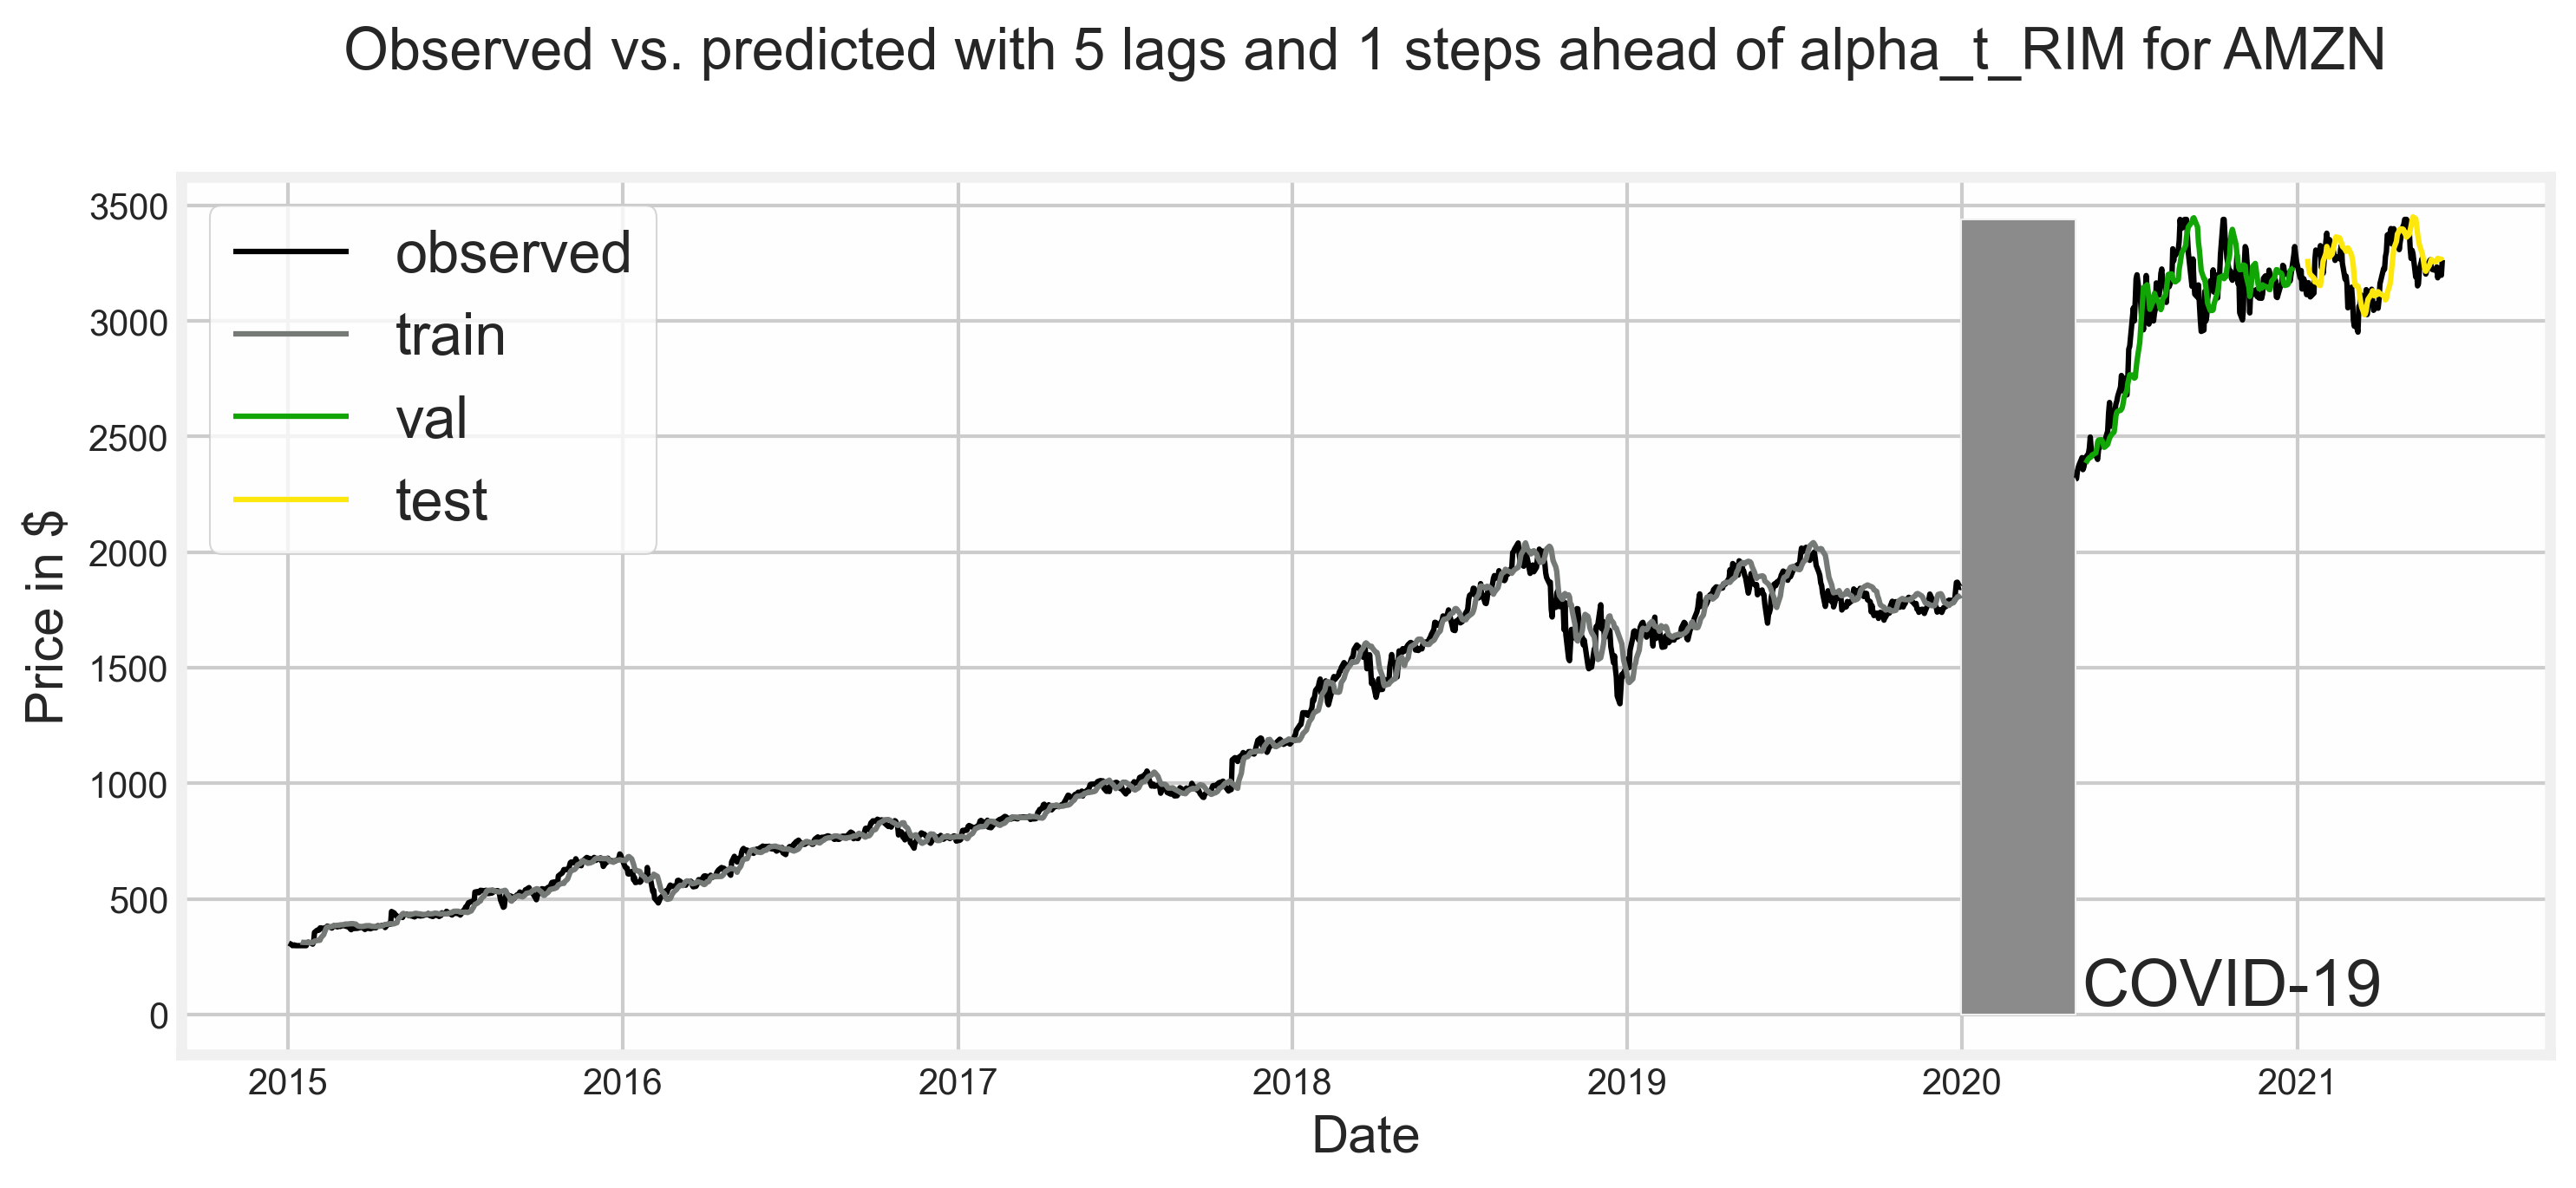

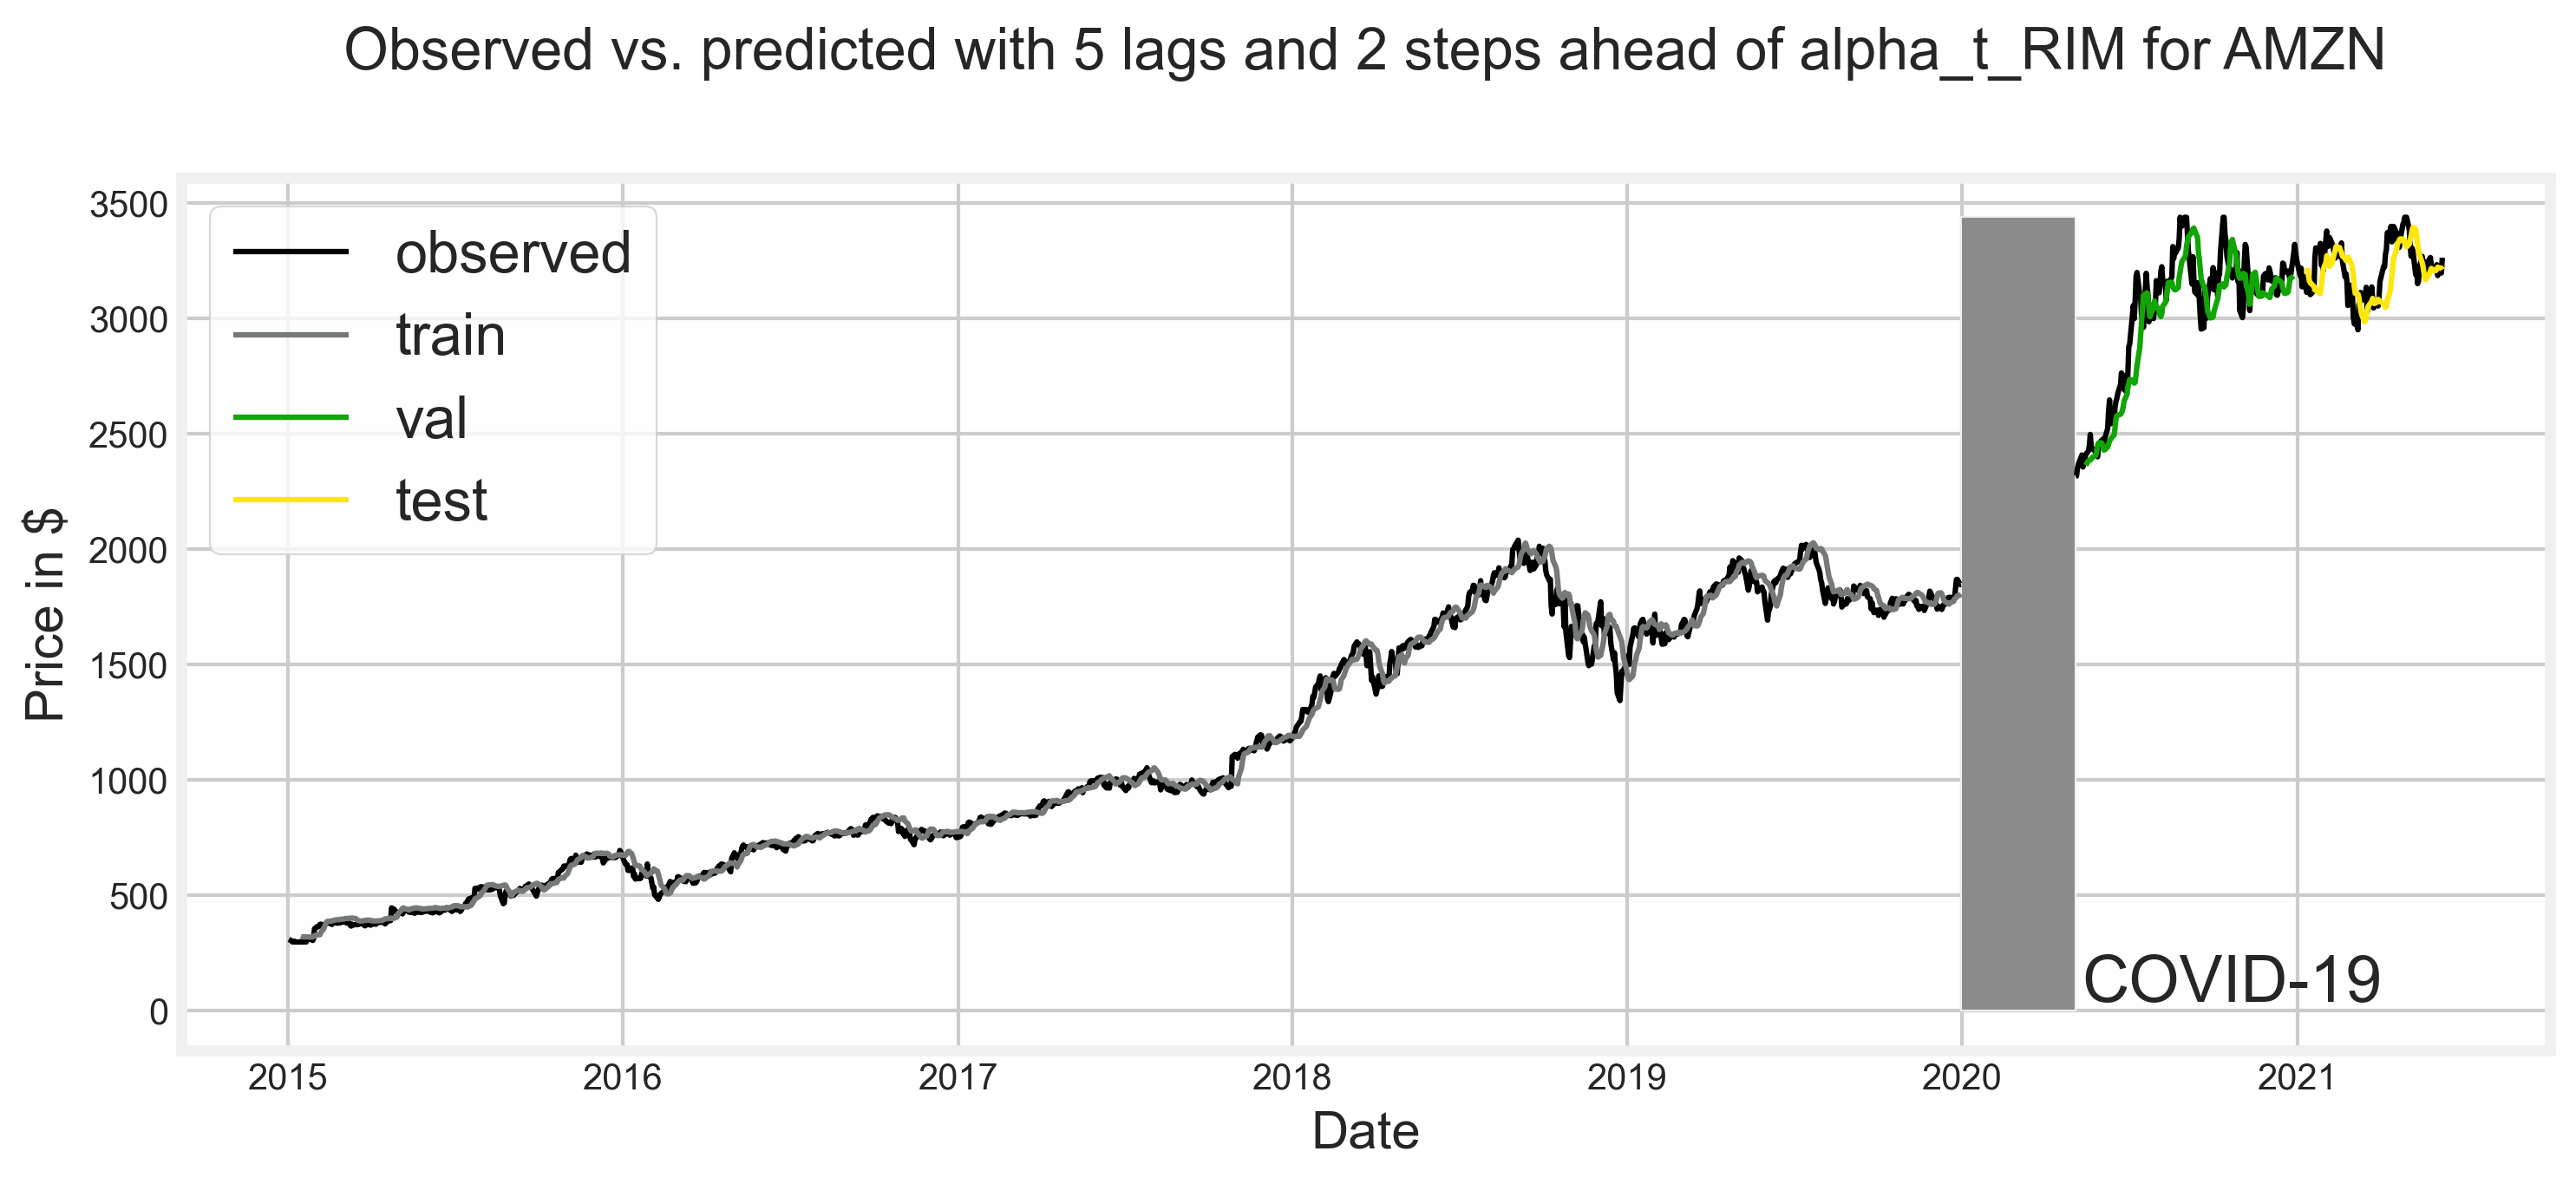

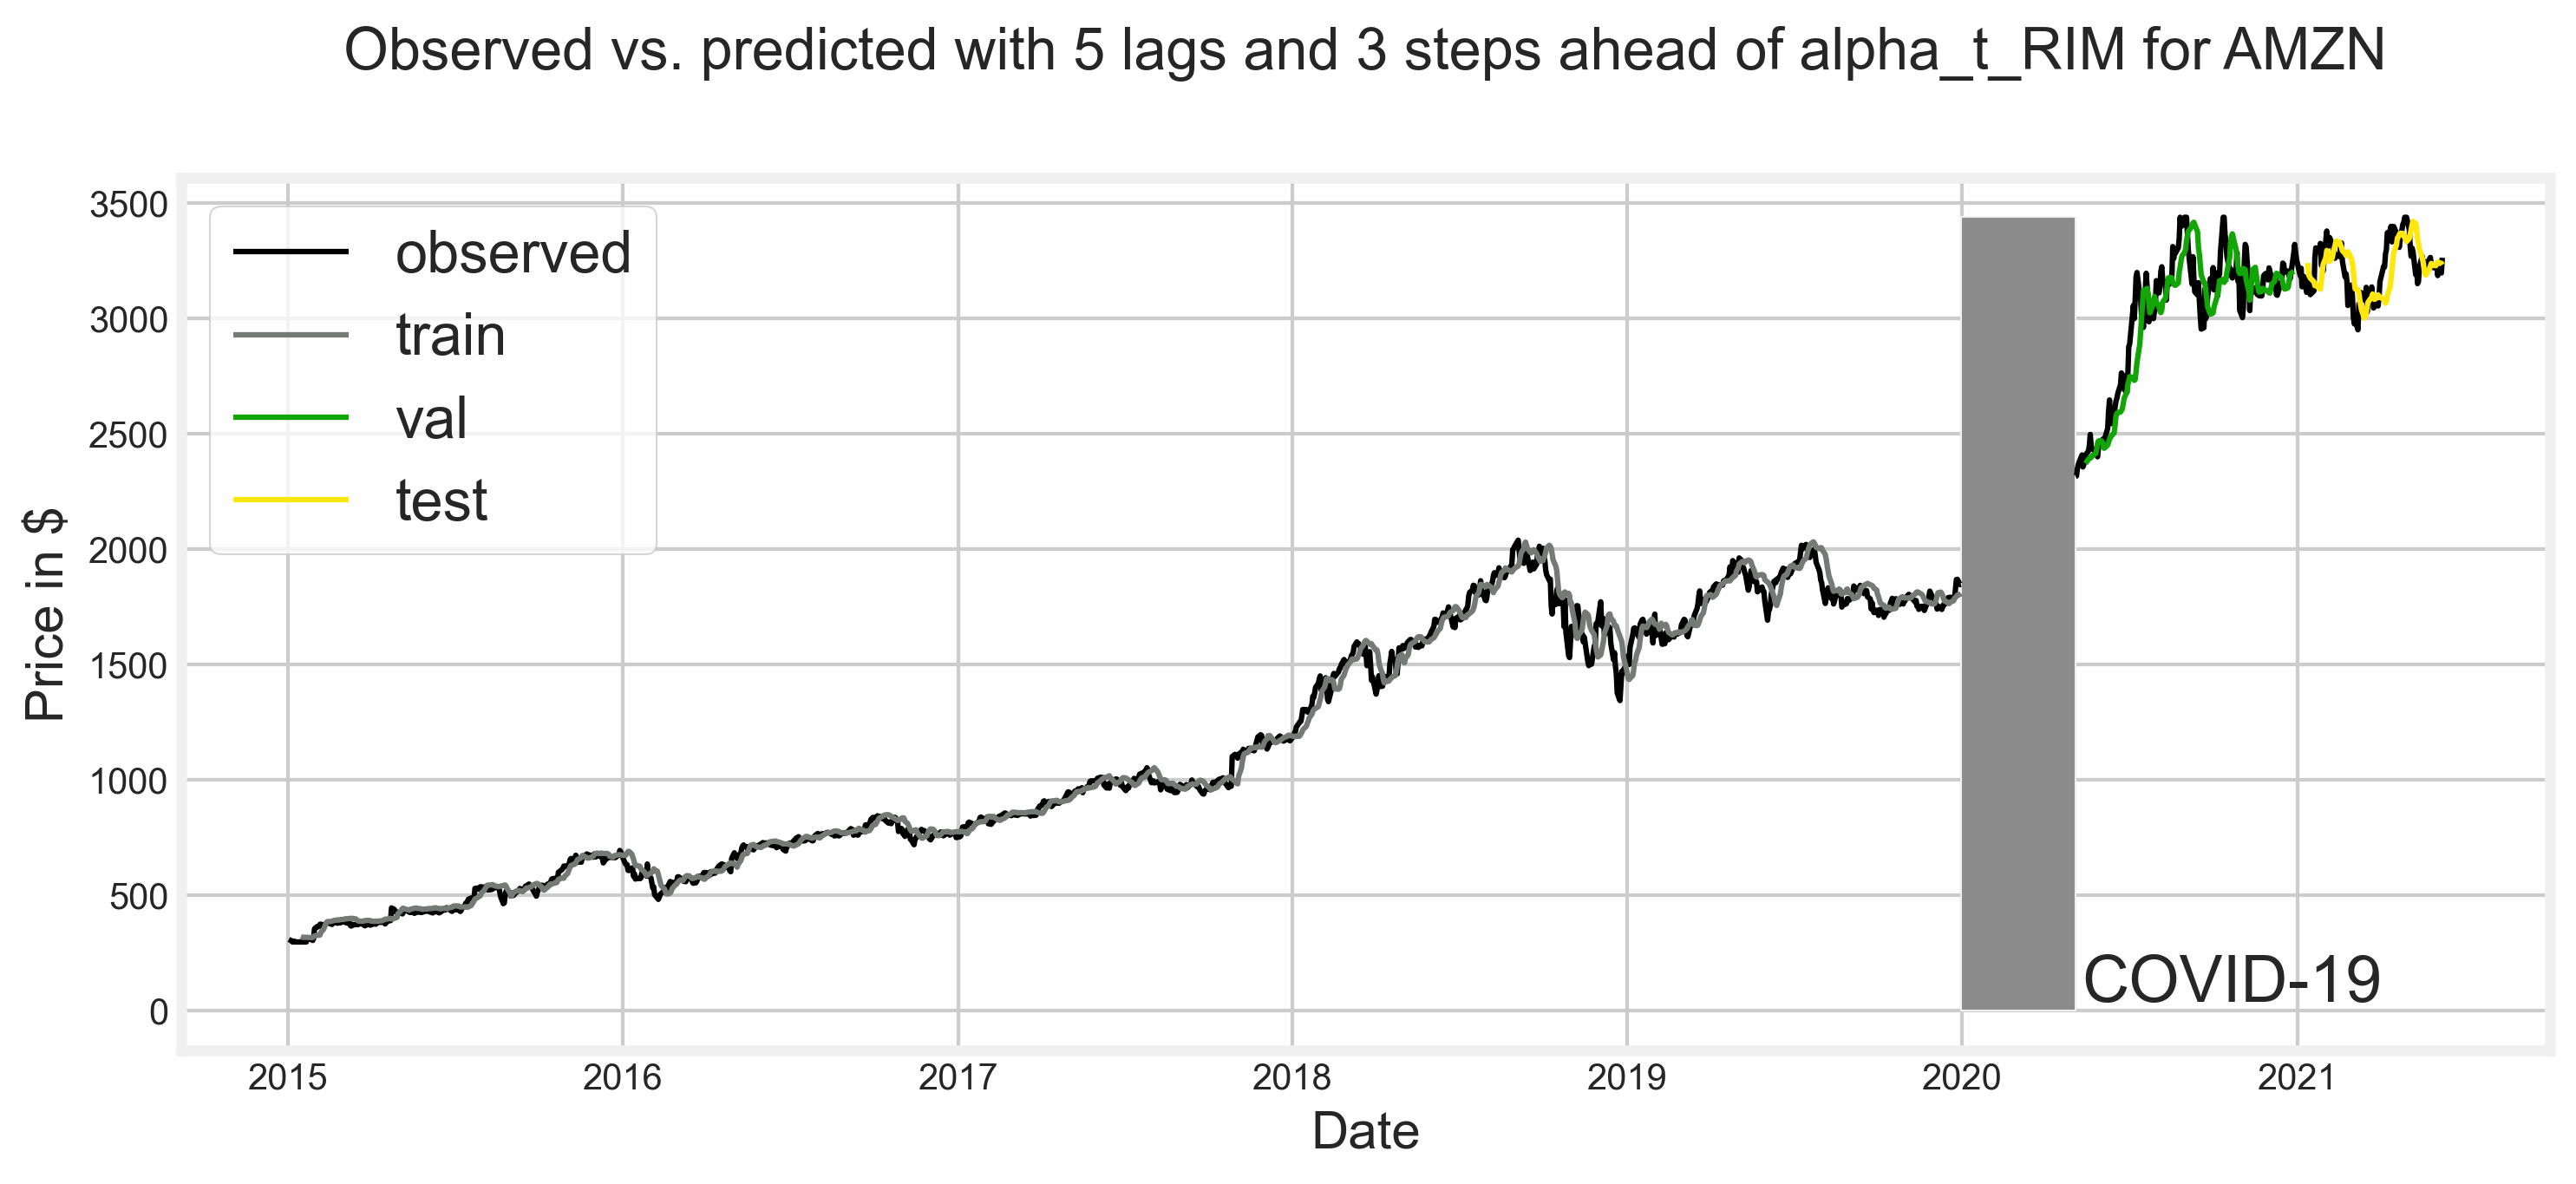

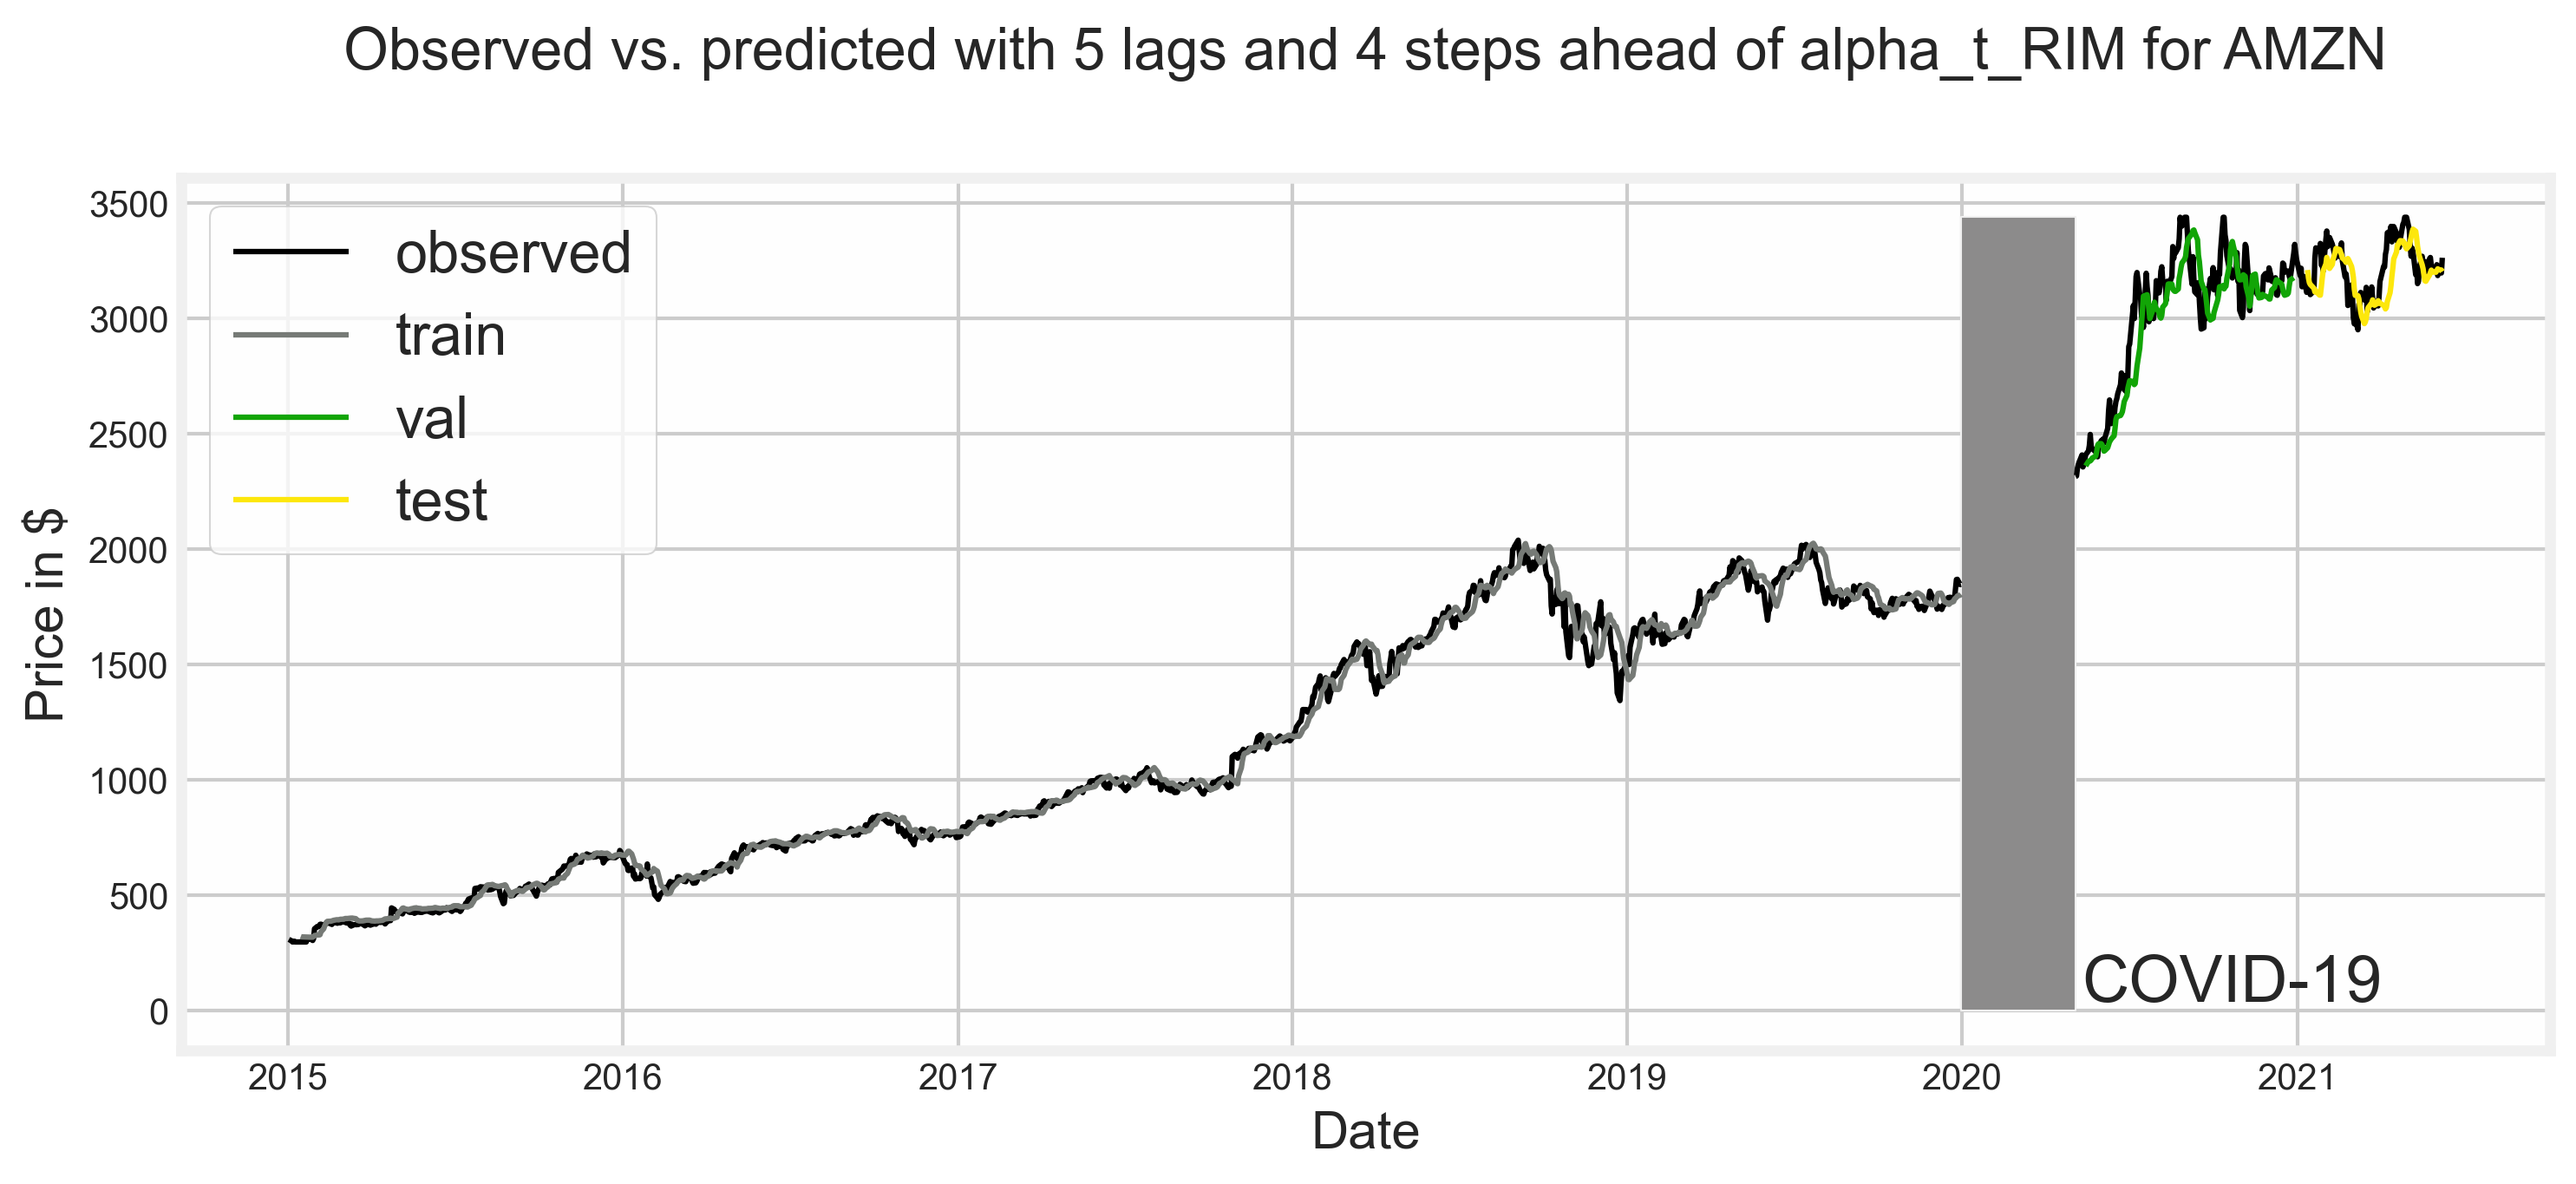

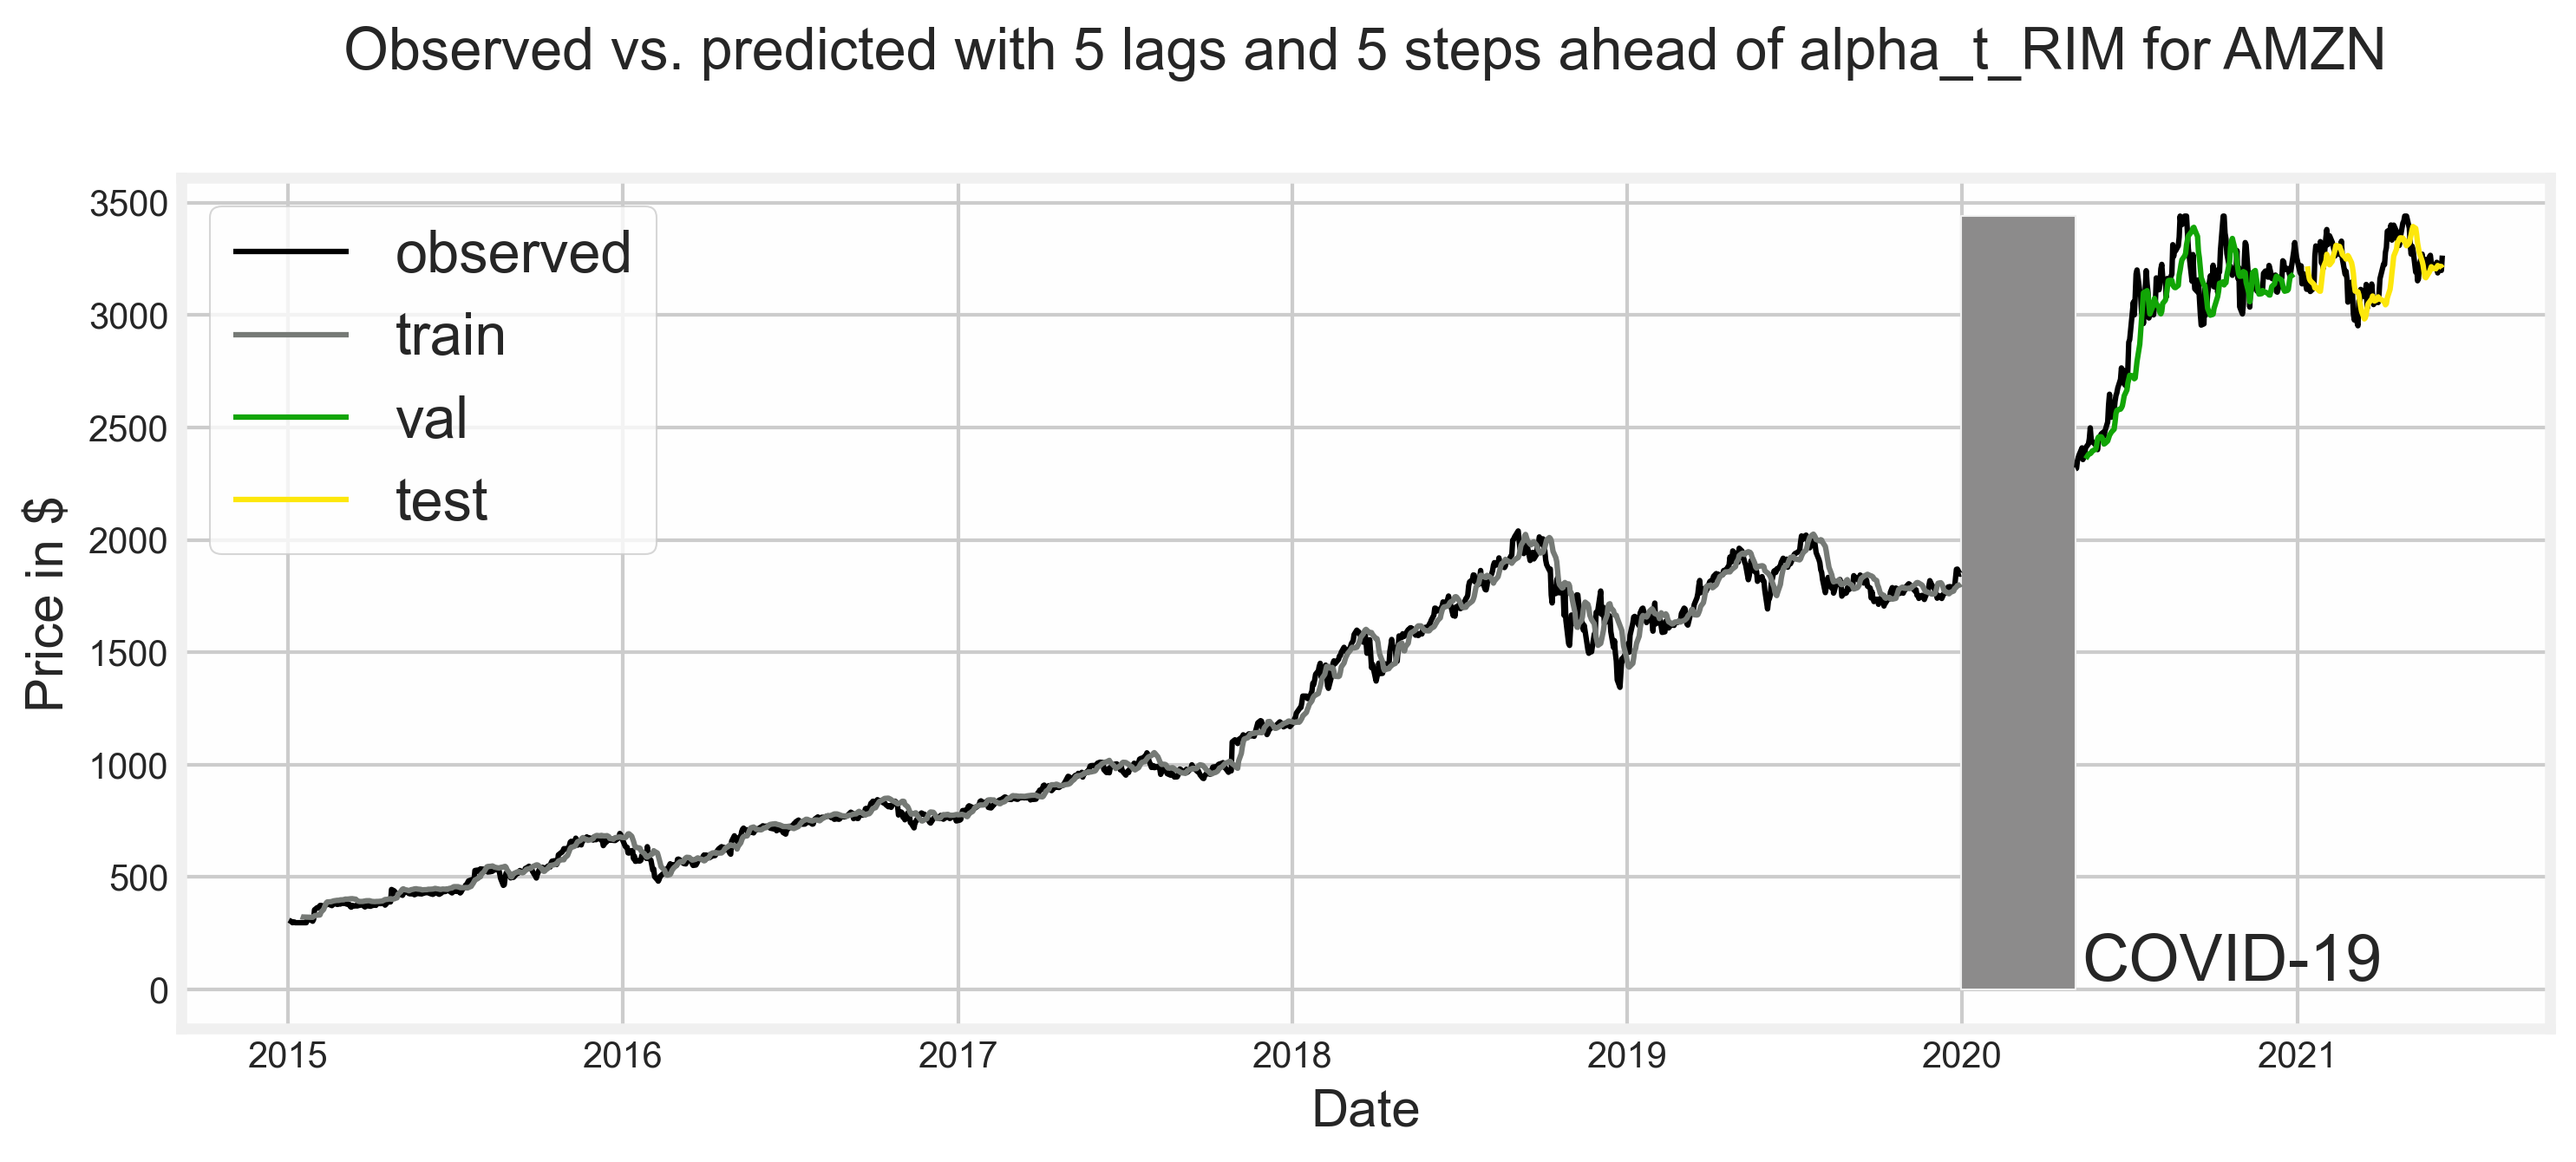

In [53]:
# rescale observed and predicted to compare
plotting.scaled_observed_vs_predicted_plot(data1, data2, key, ticker, data_train, data_val,
                                           data_test, mu, sigma, params, n_steps, n_steps_ahead, uni)

# Tensorboard

In [54]:
if uni: 
    str_path = '../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key
else: 
    str_path = '../logs/fit/'+ ticker +'_' + lags + '_multi_'+ key
path = Path(str_path)

In [55]:
path

PosixPath('../logs/fit/AMZN_5_uni_alpha_t_RIM')

In [56]:
%load_ext tensorboard

# uncomment the function below to gain more insight of the models behavior
#%tensorboard --logdir ../logs/fit/AMZN_5_uni_alpha_t_RIM